Горностаев Александр, ML-11

In [1]:
# at first, mount the drive

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [172]:
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from scipy.stats import rv_discrete

from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.compose import make_column_transformer
import numpy as np
from sklearn.decomposition import PCA

In [4]:
'''
imputes values from distribution for each given column
target missing values are np.nan
'''
class DiscreteDistributionImputer():
  def __init__(self, random_state=42):
    # contains distributions to generate random stuff from
    self.distributions = []
    # to fix randomness for result recheck
    self.random_state = random_state

  def fit(self, X, y=None):
    columns = []

    if isinstance(X, pd.DataFrame):
      columns = X.values.T
    elif isinstance(X, np.ndarray):
      columns = X.T
    else:
      print("given X is neither DataFrame nor ndarray")

    # clear distributions
    self.distributions = []
    for col in columns:
      # must consider only not nans
      notnans_mask = ~np.isnan(col)
      # must create distribution for each column now
      unique_vals, counts = np.unique(col[notnans_mask], return_counts=True)
      probabilities = counts / counts.sum()
      distribution = rv_discrete(values=(unique_vals, probabilities))
      self.distributions.append(distribution)
    
    return self

  def fit_transform(self, X, y = None):
    # fit first to create distributions
    self.fit(X, y)

    # transform
    return self.transform(X)
    

  def transform(self, X):
    columns = []

    # cast to float because only floats support np.nan
    if isinstance(X, pd.DataFrame):
      columns = X.values.T.copy().astype(np.float)
    elif isinstance(X, np.ndarray):
      columns = X.T.copy().astype(np.float)
    else:
      print("given X is neither DataFrame nor ndarray")

    for i, col in enumerate(columns):
      distribution = self.distributions[i]
      nan_cells_mask = np.isnan(col)
      # careful here, where returns a one sized tuple (<value>, )
      nan_cells_indices, = np.where(nan_cells_mask)
      random_values = distribution.rvs(size=nan_cells_indices.size)
      for index, random in zip(nan_cells_indices, random_values):
        col[index] = random

    return columns.T

  def get_params(self, deep=True):
    return {}

  def set_params(self, **kwargs):
    return self

In [5]:
'''
finds a min date per Series (of type pd.Timestamp)
then subtracts it from each date
the result per each column is a column with amount of days
'''
class DatePreprocessor():
  def __init__(self, random_state=42):
    self.min_dates = []

  def fit(self, X, y=None):
    # columns = []
    # if (len(X.shape) == 1):
    #   print("1d array is not supported, expected 2d")

    # if isinstance(X, pd.DataFrame):
    #   columns = X.values.T
    # elif isinstance(X, np.ndarray):
    #   columns = X.T
    # else:
    #   print("given X is neither DataFrame nor ndarray")

    # for i in columns:
    #   min_date, = X.min()
    #   if isinstance(min_date, pd.Timestamp):
    #     self.min_dates.append(min_date)
    #   else:
    #     print(type(min_date))
    #     print("passed column is not of np.datetime64")

    return self

  def fit_transform(self, X, y = None):
    # fit first to create distributions
    self.fit(X, y)

    # transform
    return self.transform(X)
    

  def transform(self, X):
    columns = []
    if (len(X.shape) == 1):
      print("1d array is not supported, expected 2d")

    if isinstance(X, pd.DataFrame):
      columns = X.values.T
    elif isinstance(X, np.ndarray):
      columns = X.T
    else:
      print("given X is neither DataFrame nor ndarray")

    print(columns.dtype)
    dates = np.ones(X.T.shape, dtype=np.int)

    for index, col in enumerate(columns):
      dates[index] = np.array(list(map(lambda date: pd.Timestamp(date).month, col)))

    return dates.T

  def get_params(self, deep=True):
    return {}

  def set_params(self, **kwargs):
    return self

In [50]:
'''
casts all passed columns to int

may raise error if cannot cast series to int (if, e.g., nan is encountered)
'''
class CategoricalFeaturesToIntPreprocessor(BaseEstimator, TransformerMixin):
  def __init__(self):
      pass
  
  def fit(self, X, y=None):
      return self
  
  def fit_transform(self, X, y = None):
    # fit first to create distributions
    self.fit(X, y)

    # transform
    return self.transform(X)
  
  def transform(self, X):
    columns = []
    print(type(X.head()))
    print(X.head(), X.shape)
    columns = X.T

    for index in range(len(columns)):
      columns[index] = columns[index].astype(np.int)
    
    return columns.T

In [205]:
def pandarizer(columns, *placed_to_first, **options):
    if (len(placed_to_first) != 0):
        columns = names_at_start(columns, *placed_to_first)
        
    def framerize(x):
        frame = pd.DataFrame(x, columns = columns)
        if len(options) > 0:
            int_columns = options['toint']
            for int_column in int_columns:
                frame[int_column] = frame[int_column].astype(np.int)
        return frame
            
    return FunctionTransformer(lambda x: framerize(x))

def names_at_start(columns, *placed_to_first):
    columns = columns.copy()
    if not isinstance(columns, list):
        columns = columns.tolist()
        
    for name in placed_to_first[::-1]:
        columns.remove(name)
        columns.insert(0, name)
    return columns

def without(columns, *without_names):
    columns = columns.copy()
    if not isinstance(columns, list):
        columns = columns.tolist()
        
    for name in without_names:
        columns.remove(name)
    return columns

In [104]:
col_tran = ColumnTransformer([
    ('proc', CategoricalFeaturesToIntPreprocessor(), ['build_tech', 'g_lift'])
], remainder='passthrough') 

In [206]:
pipeline = make_pipeline(
    ColumnTransformer([('date_preproc', DatePreprocessor(), ['date']),
                       ('cat_preproc', DiscreteDistributionImputer(), ['build_tech', 'g_lift']),
                       ('metro_preproc', SimpleImputer(), without(data_train.columns, 
                                                                  'date', 
                                                                  'build_tech',
                                                                  'g_lift',
                                                                  *["kw{}".format(i) for i in range(1,14)  if i != 2]
                                                                 ))
                      ]),
    pandarizer(without(data_train.columns, *["kw{}".format(i) for i in range(1,14)  if i != 2]), 'date', 'build_tech', 'g_lift'),
    'passthrough'
)

In [207]:
data_train

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
0,2011-01-01,385,NaN,1,59,3,0,25.0,NaN,2,...,0,0,0,0,0,0,0,0,0,2489000
1,2011-01-01,247,NaN,5,53,2,1,15.0,1.0,2,...,0,0,0,0,0,0,0,0,0,1995000
2,2011-01-01,115,0.0,7,61,3,0,10.0,1.0,1,...,0,0,0,0,0,0,0,0,0,3993000
3,2011-01-01,491,1.0,5,61,3,1,30.0,NaN,0,...,0,0,0,0,0,0,0,0,0,5709000
4,2011-01-01,623,NaN,3,51,2,1,30.0,NaN,1,...,0,0,0,0,0,0,0,0,0,4374000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2012-03-01,655,0.0,2,44,2,0,20.0,1.0,1,...,0,0,0,0,0,0,0,0,0,1838000
99996,2012-03-01,175,1.0,10,60,3,0,30.0,NaN,5,...,0,0,0,0,0,0,0,0,0,6355000
99997,2012-03-01,199,1.0,4,64,2,1,30.0,NaN,3,...,0,0,0,0,0,0,0,0,0,6695000
99998,2012-03-01,226,1.0,10,35,1,1,15.0,NaN,1,...,0,0,0,0,0,0,0,0,0,2544000


## Подгрузить данные



In [7]:
gdrive_path_train = "/content/drive/MyDrive/Технопарк 2021 ML/lecture05/Train.csv"
local_path_train = "Train.csv"
gdrive_path_test = "/content/drive/MyDrive/Технопарк 2021 ML/lecture05/Test.csv"
local_path_test = "Test.csv"

data_train = pd.read_csv(local_path_train, index_col=None)
data_test = pd.read_csv(local_path_test, index_col=None)

data_train['date'] = pd.to_datetime(data_train['date'])
data_test['date'] = pd.to_datetime(data_test['date'])
data_train.drop(data_train.columns[[0]], axis=1,inplace=True)
data_test.drop(data_test.columns[[0]], axis=1,inplace=True)

In [8]:
data_train.head()

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
0,2011-01-01,385,NaN,1,59,3,0,25.0,NaN,2,...,0,0,0,0,0,0,0,0,0,2489000
1,2011-01-01,247,NaN,5,53,2,1,15.0,1.0,2,...,0,0,0,0,0,0,0,0,0,1995000
2,2011-01-01,115,0.0,7,61,3,0,10.0,1.0,1,...,0,0,0,0,0,0,0,0,0,3993000
3,2011-01-01,491,1.0,5,61,3,1,30.0,NaN,0,...,0,0,0,0,0,0,0,0,0,5709000
4,2011-01-01,623,NaN,3,51,2,1,30.0,NaN,1,...,0,0,0,0,0,0,0,0,0,4374000


## Предобработка данных

Среди данных большое количество пропущенных значений в столбцах <i> build_tech, g_lift, metro_dist. </i> Все фичи имеют не строковые значения, следовательно, из предобработки данных что остается (можно) сделать:
1. Заполнить пропущенные значения
2. Понять что делать с датой
3. Понять какие данные сильно скоррелированы
4. Посмотреть на возможные выбросы

### Заполнение пропущенных значений

Прежде чем заполнять пропущенные значения, стоит взглянуть на то, как данные распределены.

<Figure size 864x864 with 0 Axes>

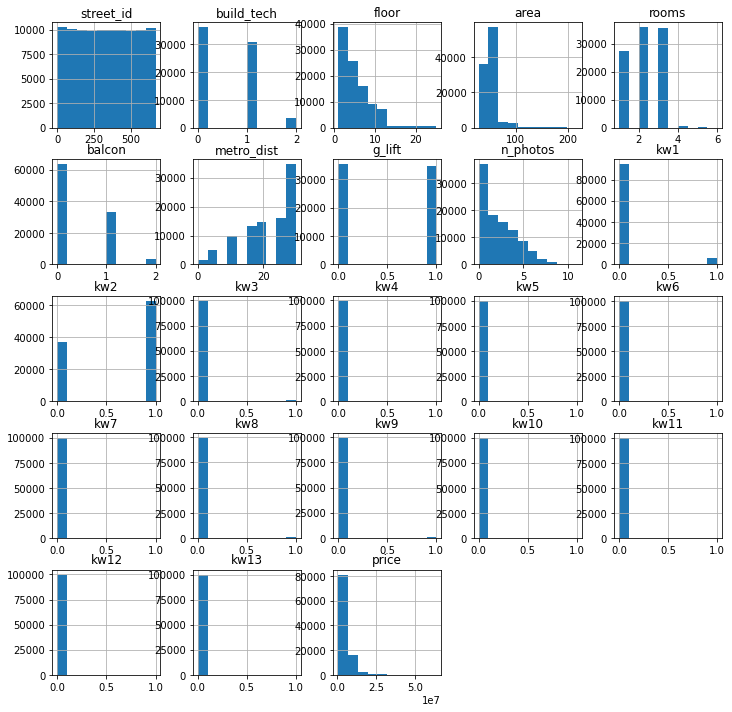

In [9]:
plt.figure(figsize=(12, 12))

data_train.hist(figsize=(12, 12))
None

Присмотримся к столбцам, где пропущены значения `['build_tech', 'g_lift', 'metro_dist']`. Для того, чтобы заполнить пропущенные значения, можно воспользоваться KNN. Для того, чтобы это сделать, я воспользуюст KNNImputer из библиотеки sklearn

Создадим часть pipeline, которая бы дополняла пропущенные данные среди указанных столбцов. 

Для категориальных данных для пропущенных значений будет выбираться случайное число из выведенного распределения, для этого используем написанный DiscreteDistributionImputer.

Для численных значений (не категориальных) будет браться число с помощью KNNImputer)

In [152]:
for i in range(1,14):
    name = 'kw{}'.format(i)
    print(data_train[name].value_counts())

0    94358
1     5642
Name: kw1, dtype: int64
1    62760
0    37240
Name: kw2, dtype: int64
0    99258
1      742
Name: kw3, dtype: int64
0    99335
1      665
Name: kw4, dtype: int64
0    99602
1      398
Name: kw5, dtype: int64
0    99815
1      185
Name: kw6, dtype: int64
0    99916
1       84
Name: kw7, dtype: int64
0    99267
1      733
Name: kw8, dtype: int64
0    99217
1      783
Name: kw9, dtype: int64
0    99796
1      204
Name: kw10, dtype: int64
0    99973
1       27
Name: kw11, dtype: int64
0    99822
1      178
Name: kw12, dtype: int64
0    99977
1       23
Name: kw13, dtype: int64


По всем столбцам kw, исключая 2, очень сильный дизбаланс классов. Надо их дропнуть 

### Что делать с датами

По идее, чем жилье новее, там оно должно быть дороже. Поэтому можно перевести даты в просто какое-то число-отсчет. Тогда, если эта гипотеза верна, в корреляционной таблице будет видно, что чем это число больше, тем выше становится цена.

In [ ]:
days_from_something = (data_train['date'] - data_train['date'].min())
days = days_from_something.dt.days

(array([16656., 11090., 11238., 16792., 11047., 11193.,  5532.,     0.,
            0., 16452.]),
 array([  0.,  70., 140., 210., 280., 350., 420., 490., 560., 630., 700.]),
 <a list of 10 Patch objects>)

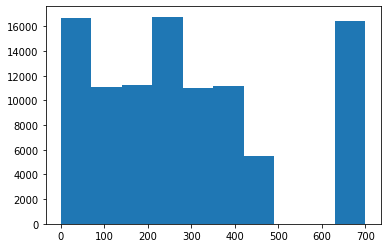

In [ ]:
plt.hist(days)

Интересно, распределение выглядит так, как будто среди 500 и 600 дней не было ни одного объявления. В любом случае, прежде чем кормить даты, нужно в препроцессинг добавить препроцессор, который бы их обрабатывал. См. DatePreprocessor

### Посмотрим на то, как данные скоррелированы

Для того чтобы это сделать, соберу пайплайн

In [ ]:
metro_dist_imputer = ('metro_imp', KNNImputer(), make_column_selector(pattern='metro_dist', dtype_include=np.float64))
categorial_imputer = ('category_imp', DiscreteDistributionImputer(), ['build_tech', 'g_lift'])
dates_preprocessor = ('dates_preproc', DatePreprocessor(), ['date'])
preproc = ColumnTransformer([
                             metro_dist_imputer,
                             categorial_imputer,
                             dates_preprocessor
], remainder='passthrough', n_jobs=-1)
preproc.fit(data_train)
preprocessed = preproc.transform(data_train)
pd_preprocessed = pd.DataFrame(preprocessed)

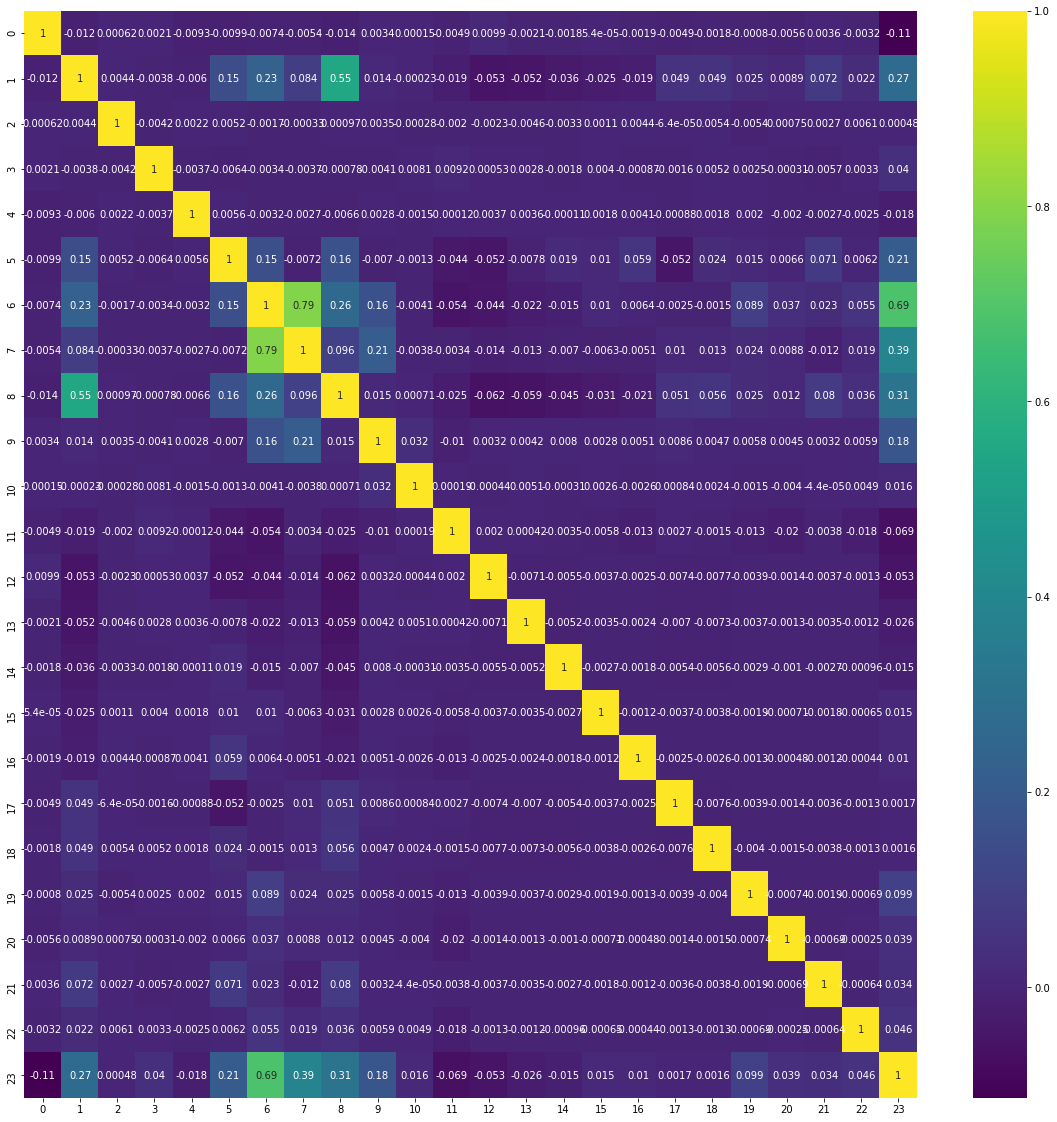

In [ ]:
plt.figure(figsize=(20, 20))
# корреляция между признаками
sns.heatmap(pd_preprocessed.corr(), annot=True, cmap="viridis")

Какие-то фичи находятся в корреляции, но она не такая сильная. Посмотрим максимальное значение корреляции

In [ ]:
correlation = pd_preprocessed.corr()
correlation[correlation == 1.] = 0
correlation.max(axis=1).max()

0.7919025941879708

In [ ]:
correlation.min(axis=1).min()

-0.11333445777812343

Максимальная корреляция - 0.79. Этого недостаточно, чтобы убрать какие-то "лишние" фичи

### Заключение по предобработке

Были дозаполнены пустые значения для metro_dist, build_tech, g_lift.

Даты были преобразованы в числа, которые соответствуют порядковому номеру дня после самого раннего дня в выборке 

## Поиск модели для предсказания стоимости квартиры

In [161]:
X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(data_train.iloc[:, :-1], data_train.iloc[:, -1], shuffle=True)

Относительная погрешность


In [166]:
def relative_error(y_true, y_pred): 
  return 1 - (np.abs((y_true - y_pred) / y_train_test).mean())

### ElasticNet

Не то чтобы я был уверен, что она даст хорошую точность, но попробовать стоит

#### Тестирование модели

In [ ]:
# pipeline = Pipeline(steps=[('preproc', preproc), scaler, ('model', ElasticNet())])
# pipeline.fit(X_train_train, y_train_train)
# y_train_test_pred = pipeline.predict(X_train_test)
# mean_absolute_error(y_train_test, y_train_test_pred)
# relative_error(y_train_test, y_train_test_pred)

Получившаяся точность очень низкая

### Random Forest

Что-то я забеспокоился после такой низкой точности. Попробую-ка я сразу бахнуть рандом форест, может, я данные так плохо обрабатываю? Если так, то рандом форест даст какую-нибудь низкую точность

In [ ]:
# from sklearn.ensemble import RandomForestRegressor

In [ ]:
# pipeline = Pipeline(steps=[('preproc', preproc)
                           ,('model', RandomForestRegressor(n_jobs=-1,min_samples_leaf=5, n_estimators=300))])

In [ ]:
# y_train_train
# pipeline.fit(X_train_train, y_train_train)
# y_train_test_pred = pipeline.predict(X_train_test)
# relative_error(y_train_test, y_train_test_pred)

55355    41746000
27474     1000000
43400     3214000
12853     2266000
13425     4808000
           ...   
32950     3170000
14146     4006000
68478     6685000
75291     4719000
98239     3118000
Name: price, Length: 75000, dtype: int64

### CatBoost 

In [149]:
from catboost import Pool, CatBoostRegressor

In [222]:
model = CatBoostRegressor(learning_rate=0.1, depth=8, loss_function='MAE',cat_features=['build_tech', 'g_lift', 'kw2', 'balcon'],early_stopping_rounds=22, eval_metric = 'MAE') 

In [174]:
# grid = {'learning_rate': [0.03, 0.1, 0.5, 1],
#         'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 3, 5, 7, 9],
#         'max_leaves': [12, 32, 48, 58],
#         'iterations':[500, 1000, 1500]}

# grid_search_result = model.grid_search(grid, 
#                                        X=data_train.iloc[:, :-1], 
#                                        y=data_train.iloc[:, -1], 
#                                        plot=True)
None

In [175]:
X_labels = X_train_train.columns
X_labels

Index(['date', 'street_id', 'build_tech', 'floor', 'area', 'rooms', 'balcon',
       'metro_dist', 'g_lift', 'n_photos', 'kw1', 'kw2', 'kw3', 'kw4', 'kw5',
       'kw6', 'kw7', 'kw8', 'kw9', 'kw10', 'kw11', 'kw12', 'kw13'],
      dtype='object')

In [210]:
preprocess_model = make_pipeline(
    make_column_transformer(
        # convert date to months
        (DatePreprocessor(), ['date']),
        # fill nans for columns using their distributions
        (DiscreteDistributionImputer(), ['build_tech', 'g_lift']),
        # fill left nans simply
        remainder=SimpleImputer()
    ),
    # pandarize for other columntransform conversion, date, build_Tech and g_lift labels go first after first CT conversion
    pandarizer(X_labels, 'date', 'build_tech', 'g_lift'),
    # drop kw columns that are highly disbalanced
    make_column_transformer(
        ('drop', ["kw{}".format(i) for i in range(1, 14) if i != 2]),
        remainder='passthrough'
    ),
    # pandarize again to check that everything is as must
    pandarizer(without(X_labels, *["kw{}".format(i) for i in range(1, 14) if i != 2]), 
               'date', 'build_tech', 'g_lift',
               toint=['date', 'build_tech', 'g_lift', 'street_id', 'floor', 'area', 'rooms', 'balcon', 'n_photos', 'kw2']
              ),
    'passthrough'
)

In [220]:
preprocess_model.fit_transform(data_train.iloc[:, :-1])

datetime64[ns]


,date,build_tech,g_lift,street_id,floor,area,rooms,balcon,metro_dist,n_photos,kw2
0,1,0,1,385,1,59,3,0,25.0,2,1
1,1,1,1,247,5,53,2,1,15.0,2,1
2,1,0,1,115,7,61,3,0,10.0,1,1
3,1,1,0,491,5,61,3,1,30.0,0,1
4,1,0,1,623,3,51,2,1,30.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
99995,3,0,1,655,2,44,2,0,20.0,1,1
99996,3,1,0,175,10,60,3,0,30.0,5,0
99997,3,1,0,199,4,64,2,1,30.0,3,1
99998,3,1,1,226,10,35,1,1,15.0,1,1


In [223]:
# как я понял из доки, кросс вал тут встроена в гридсерч
# беру 5 фолдов и размер трейна 0.8

grid = {'learning_rate': [0.1,0.5,1],
        'depth': [8,10,12],
        'iterations': [250,500,1000]}

grid_search_result = model.grid_search(grid, 
                                       X=preprocess_model.fit_transform(data_train.iloc[:, :-1]), 
                                       y=data_train.iloc[:, -1],
                                       verbose = False,
                                       partition_random_seed = 123,
                                       cv = 5,
                                       train_size=0.8,
                                       plot=False)


datetime64[ns]
0:	learn: 4408528.2390880	test: 4409764.1490799	best: 4409764.1490799 (0)	total: 49.3ms	remaining: 12.3s
1:	learn: 4054704.5975913	test: 4055657.7083219	best: 4055657.7083219 (1)	total: 85.5ms	remaining: 10.6s
2:	learn: 3736951.1854545	test: 3737286.9541843	best: 3737286.9541843 (2)	total: 134ms	remaining: 11s
3:	learn: 3446557.6749870	test: 3446266.1435240	best: 3446266.1435240 (3)	total: 196ms	remaining: 12s
4:	learn: 3221585.2778167	test: 3220360.9258686	best: 3220360.9258686 (4)	total: 218ms	remaining: 10.7s
5:	learn: 3016213.3603673	test: 3014191.5163600	best: 3014191.5163600 (5)	total: 268ms	remaining: 10.9s
6:	learn: 2813286.1045694	test: 2809945.6074311	best: 2809945.6074311 (6)	total: 323ms	remaining: 11.2s
7:	learn: 2653835.0556162	test: 2650192.1805369	best: 2650192.1805369 (7)	total: 375ms	remaining: 11.3s
8:	learn: 2502775.8020535	test: 2498988.8828360	best: 2498988.8828360 (8)	total: 424ms	remaining: 11.4s
9:	learn: 2359615.7081880	test: 2355540.6340242	bes

80:	learn: 1495763.7734103	test: 1508689.9196969	best: 1508689.9196969 (80)	total: 4.1s	remaining: 8.56s
81:	learn: 1493813.3289547	test: 1506752.1610986	best: 1506752.1610986 (81)	total: 4.16s	remaining: 8.53s
82:	learn: 1492778.8310985	test: 1505753.1113223	best: 1505753.1113223 (82)	total: 4.21s	remaining: 8.48s
83:	learn: 1491187.5325608	test: 1504486.9256090	best: 1504486.9256090 (83)	total: 4.26s	remaining: 8.43s
84:	learn: 1490484.2334487	test: 1504030.4155537	best: 1504030.4155537 (84)	total: 4.31s	remaining: 8.37s
85:	learn: 1489856.2893024	test: 1503478.6893680	best: 1503478.6893680 (85)	total: 4.38s	remaining: 8.35s
86:	learn: 1488619.7373396	test: 1502380.2500317	best: 1502380.2500317 (86)	total: 4.43s	remaining: 8.3s
87:	learn: 1487636.1647794	test: 1501518.5481764	best: 1501518.5481764 (87)	total: 4.49s	remaining: 8.26s
88:	learn: 1487373.0328641	test: 1501314.2569460	best: 1501314.2569460 (88)	total: 4.53s	remaining: 8.2s
89:	learn: 1485836.1003546	test: 1499733.1928790	

160:	learn: 1408810.1038859	test: 1430574.8101096	best: 1430574.8101096 (160)	total: 8.38s	remaining: 4.63s
161:	learn: 1408026.0118467	test: 1430021.0519306	best: 1430021.0519306 (161)	total: 8.44s	remaining: 4.58s
162:	learn: 1407686.4973515	test: 1429618.3875193	best: 1429618.3875193 (162)	total: 8.49s	remaining: 4.53s
163:	learn: 1406911.9126903	test: 1429002.8642162	best: 1429002.8642162 (163)	total: 8.54s	remaining: 4.48s
164:	learn: 1406050.1358191	test: 1428211.1674186	best: 1428211.1674186 (164)	total: 8.6s	remaining: 4.43s
165:	learn: 1404556.4893329	test: 1426538.3784284	best: 1426538.3784284 (165)	total: 8.65s	remaining: 4.38s
166:	learn: 1404049.3869877	test: 1426239.0275335	best: 1426239.0275335 (166)	total: 8.71s	remaining: 4.33s
167:	learn: 1403288.5362816	test: 1425490.6764485	best: 1425490.6764485 (167)	total: 8.76s	remaining: 4.28s
168:	learn: 1402716.8385912	test: 1424982.2672954	best: 1424982.2672954 (168)	total: 8.81s	remaining: 4.22s
169:	learn: 1402161.9200094	t

239:	learn: 1346956.7439684	test: 1374555.9407002	best: 1374555.9407002 (239)	total: 12.7s	remaining: 531ms
240:	learn: 1346349.2234441	test: 1374019.7089091	best: 1374019.7089091 (240)	total: 12.8s	remaining: 478ms
241:	learn: 1345380.0672383	test: 1373279.4533576	best: 1373279.4533576 (241)	total: 12.8s	remaining: 425ms
242:	learn: 1344674.9823181	test: 1372611.3744124	best: 1372611.3744124 (242)	total: 12.9s	remaining: 372ms
243:	learn: 1344177.6045379	test: 1372122.4251246	best: 1372122.4251246 (243)	total: 13s	remaining: 319ms
244:	learn: 1343396.4928653	test: 1371534.7463186	best: 1371534.7463186 (244)	total: 13s	remaining: 266ms
245:	learn: 1342570.9709610	test: 1370605.0525195	best: 1370605.0525195 (245)	total: 13.1s	remaining: 212ms
246:	learn: 1342144.5230549	test: 1370429.9484907	best: 1370429.9484907 (246)	total: 13.1s	remaining: 159ms
247:	learn: 1341092.9261885	test: 1369416.9335940	best: 1369416.9335940 (247)	total: 13.2s	remaining: 106ms
248:	learn: 1340725.4301113	test

68:	learn: 1309450.8630989	test: 1356586.6476614	best: 1356176.3951271 (66)	total: 3.68s	remaining: 9.65s
69:	learn: 1307128.4698856	test: 1354099.1708335	best: 1354099.1708335 (69)	total: 3.73s	remaining: 9.59s
70:	learn: 1303033.3134227	test: 1350076.6589643	best: 1350076.6589643 (70)	total: 3.78s	remaining: 9.52s
71:	learn: 1301836.1439651	test: 1350133.8416089	best: 1350076.6589643 (70)	total: 3.82s	remaining: 9.45s
72:	learn: 1298582.9958994	test: 1346968.5583210	best: 1346968.5583210 (72)	total: 3.88s	remaining: 9.4s
73:	learn: 1296061.1568783	test: 1343819.3380180	best: 1343819.3380180 (73)	total: 3.94s	remaining: 9.37s
74:	learn: 1294710.4343091	test: 1343692.6081221	best: 1343692.6081221 (74)	total: 3.99s	remaining: 9.3s
75:	learn: 1293422.6909748	test: 1342647.7844251	best: 1342647.7844251 (75)	total: 4.03s	remaining: 9.23s
76:	learn: 1291694.1069369	test: 1341697.0850906	best: 1341697.0850906 (76)	total: 4.08s	remaining: 9.17s
77:	learn: 1290683.6964448	test: 1341543.0343724

146:	learn: 1181978.7493173	test: 1276816.7839260	best: 1276816.7839260 (146)	total: 7.91s	remaining: 5.54s
147:	learn: 1181358.4867816	test: 1276211.1470809	best: 1276211.1470809 (147)	total: 7.96s	remaining: 5.48s
148:	learn: 1180682.9300019	test: 1276036.0078008	best: 1276036.0078008 (148)	total: 8.01s	remaining: 5.43s
149:	learn: 1179644.4110914	test: 1275730.2322209	best: 1275730.2322209 (149)	total: 8.06s	remaining: 5.37s
150:	learn: 1178372.6372449	test: 1275482.9450718	best: 1275482.9450718 (150)	total: 8.11s	remaining: 5.32s
151:	learn: 1176591.9976509	test: 1273867.3614579	best: 1273867.3614579 (151)	total: 8.17s	remaining: 5.27s
152:	learn: 1174333.3686221	test: 1272717.0026075	best: 1272717.0026075 (152)	total: 8.22s	remaining: 5.21s
153:	learn: 1173133.8731744	test: 1272276.3802595	best: 1272276.3802595 (153)	total: 8.27s	remaining: 5.16s
154:	learn: 1170479.3437096	test: 1271265.0048613	best: 1271265.0048613 (154)	total: 8.32s	remaining: 5.1s
155:	learn: 1170100.8954758	t

224:	learn: 1117092.0264938	test: 1250493.2280980	best: 1250493.2280980 (224)	total: 11.9s	remaining: 1.32s
225:	learn: 1116891.5613355	test: 1250384.5265919	best: 1250384.5265919 (225)	total: 11.9s	remaining: 1.27s
226:	learn: 1115717.5865273	test: 1250265.9792002	best: 1250265.9792002 (226)	total: 12s	remaining: 1.21s
227:	learn: 1115226.9642580	test: 1250434.1458004	best: 1250265.9792002 (226)	total: 12s	remaining: 1.16s
228:	learn: 1114297.8030953	test: 1249715.0544521	best: 1249715.0544521 (228)	total: 12.1s	remaining: 1.11s
229:	learn: 1113559.9453679	test: 1249489.7612173	best: 1249489.7612173 (229)	total: 12.1s	remaining: 1.05s
230:	learn: 1113444.6273236	test: 1249460.0570758	best: 1249460.0570758 (230)	total: 12.2s	remaining: 1s
231:	learn: 1113059.9719169	test: 1249270.0549253	best: 1249270.0549253 (231)	total: 12.2s	remaining: 947ms
232:	learn: 1112839.2846643	test: 1248926.1193615	best: 1248926.1193615 (232)	total: 12.3s	remaining: 894ms
233:	learn: 1111428.1606920	test: 1

54:	learn: 1281578.3624990	test: 1355530.0499990	best: 1355530.0499990 (54)	total: 2.9s	remaining: 10.3s
55:	learn: 1278935.4124990	test: 1353581.0499990	best: 1353581.0499990 (55)	total: 2.96s	remaining: 10.3s
56:	learn: 1272722.9749990	test: 1348356.9499990	best: 1348356.9499990 (56)	total: 3.01s	remaining: 10.2s
57:	learn: 1270043.9124990	test: 1346669.0499990	best: 1346669.0499990 (57)	total: 3.06s	remaining: 10.1s
58:	learn: 1267848.5499990	test: 1346600.4999990	best: 1346600.4999990 (58)	total: 3.11s	remaining: 10.1s
59:	learn: 1265763.6374990	test: 1343934.4999990	best: 1343934.4999990 (59)	total: 3.15s	remaining: 9.99s
60:	learn: 1260221.3249990	test: 1339444.9999990	best: 1339444.9999990 (60)	total: 3.2s	remaining: 9.91s
61:	learn: 1257192.7624990	test: 1340451.2999990	best: 1339444.9999990 (60)	total: 3.25s	remaining: 9.86s
62:	learn: 1254010.0499990	test: 1335668.6999990	best: 1335668.6999990 (62)	total: 3.3s	remaining: 9.8s
63:	learn: 1253087.2624990	test: 1335866.0999990	b

132:	learn: 1142256.1999990	test: 1308772.2999850	best: 1308377.5999991 (122)	total: 7.07s	remaining: 6.22s
133:	learn: 1140963.4749971	test: 1307760.5999607	best: 1307760.5999607 (133)	total: 7.12s	remaining: 6.16s
134:	learn: 1140304.3499955	test: 1308319.2499482	best: 1307760.5999607 (133)	total: 7.17s	remaining: 6.11s
135:	learn: 1139793.4249971	test: 1308708.6999931	best: 1307760.5999607 (133)	total: 7.22s	remaining: 6.05s
136:	learn: 1137471.8624994	test: 1307432.3500059	best: 1307432.3500059 (136)	total: 7.29s	remaining: 6.01s
137:	learn: 1135544.4874971	test: 1305861.9999596	best: 1305861.9999596 (137)	total: 7.36s	remaining: 5.97s
138:	learn: 1133441.5000015	test: 1304157.3499078	best: 1304157.3499078 (138)	total: 7.41s	remaining: 5.91s
139:	learn: 1132109.5375027	test: 1304735.4500951	best: 1304157.3499078 (138)	total: 7.45s	remaining: 5.86s
140:	learn: 1130613.6874962	test: 1305111.1501745	best: 1304157.3499078 (138)	total: 7.5s	remaining: 5.8s
141:	learn: 1130024.4375028	te

36:	learn: 1577501.7808874	test: 1581393.4974576	best: 1581393.4974576 (36)	total: 1.92s	remaining: 24s
37:	learn: 1572932.5806077	test: 1576780.0146065	best: 1576780.0146065 (37)	total: 1.96s	remaining: 23.9s
38:	learn: 1570186.6743157	test: 1574654.2840864	best: 1574654.2840864 (38)	total: 2.03s	remaining: 24s
39:	learn: 1566979.8573840	test: 1571777.3148463	best: 1571777.3148463 (39)	total: 2.07s	remaining: 23.9s
40:	learn: 1564602.7224694	test: 1569414.0954859	best: 1569414.0954859 (40)	total: 2.12s	remaining: 23.8s
41:	learn: 1561122.8008493	test: 1566040.9798889	best: 1566040.9798889 (41)	total: 2.18s	remaining: 23.8s
42:	learn: 1558317.6434980	test: 1563815.8067306	best: 1563815.8067306 (42)	total: 2.23s	remaining: 23.7s
43:	learn: 1555961.5081805	test: 1561339.1160251	best: 1561339.1160251 (43)	total: 2.28s	remaining: 23.6s
44:	learn: 1554455.5222590	test: 1559805.8244303	best: 1559805.8244303 (44)	total: 2.33s	remaining: 23.6s
45:	learn: 1552503.4431941	test: 1557785.4302687	b

117:	learn: 1456119.1604149	test: 1474688.7988186	best: 1474688.7988186 (117)	total: 5.93s	remaining: 19.2s
118:	learn: 1455613.8329165	test: 1474298.0173253	best: 1474298.0173253 (118)	total: 5.98s	remaining: 19.2s
119:	learn: 1454450.2770060	test: 1473103.4881434	best: 1473103.4881434 (119)	total: 6.03s	remaining: 19.1s
120:	learn: 1453184.2692816	test: 1472079.9311752	best: 1472079.9311752 (120)	total: 6.08s	remaining: 19.1s
121:	learn: 1451922.9684673	test: 1470928.3998932	best: 1470928.3998932 (121)	total: 6.13s	remaining: 19s
122:	learn: 1449681.7043532	test: 1468696.0170823	best: 1468696.0170823 (122)	total: 6.18s	remaining: 18.9s
123:	learn: 1448616.5027998	test: 1467505.6717777	best: 1467505.6717777 (123)	total: 6.24s	remaining: 18.9s
124:	learn: 1448000.5506094	test: 1467011.2539275	best: 1467011.2539275 (124)	total: 6.29s	remaining: 18.9s
125:	learn: 1447201.4979896	test: 1466271.6174496	best: 1466271.6174496 (125)	total: 6.35s	remaining: 18.9s
126:	learn: 1446658.9649211	te

196:	learn: 1377844.6233744	test: 1401987.6545157	best: 1401987.6545157 (196)	total: 10.1s	remaining: 15.6s
197:	learn: 1377517.5878170	test: 1401699.0165470	best: 1401699.0165470 (197)	total: 10.2s	remaining: 15.5s
198:	learn: 1375675.9135175	test: 1399974.1571682	best: 1399974.1571682 (198)	total: 10.2s	remaining: 15.5s
199:	learn: 1375106.5710691	test: 1399414.9336288	best: 1399414.9336288 (199)	total: 10.3s	remaining: 15.4s
200:	learn: 1374178.5211227	test: 1398615.1823276	best: 1398615.1823276 (200)	total: 10.3s	remaining: 15.4s
201:	learn: 1373036.7371647	test: 1397504.7524464	best: 1397504.7524464 (201)	total: 10.4s	remaining: 15.3s
202:	learn: 1371967.3233843	test: 1396562.5606837	best: 1396562.5606837 (202)	total: 10.4s	remaining: 15.3s
203:	learn: 1371506.4904233	test: 1396172.0982493	best: 1396172.0982493 (203)	total: 10.5s	remaining: 15.2s
204:	learn: 1370598.2436903	test: 1395260.6869415	best: 1395260.6869415 (204)	total: 10.6s	remaining: 15.2s
205:	learn: 1370411.0535782	

277:	learn: 1322046.5367372	test: 1353666.9475504	best: 1353666.9475504 (277)	total: 14.4s	remaining: 11.5s
278:	learn: 1321655.8576627	test: 1353313.1540964	best: 1353313.1540964 (278)	total: 14.4s	remaining: 11.4s
279:	learn: 1321002.9010559	test: 1352436.8008080	best: 1352436.8008080 (279)	total: 14.5s	remaining: 11.4s
280:	learn: 1320530.4591958	test: 1352036.3531421	best: 1352036.3531421 (280)	total: 14.5s	remaining: 11.3s
281:	learn: 1319591.2713796	test: 1351071.5085924	best: 1351071.5085924 (281)	total: 14.6s	remaining: 11.2s
282:	learn: 1318916.1057623	test: 1350350.0841872	best: 1350350.0841872 (282)	total: 14.6s	remaining: 11.2s
283:	learn: 1318412.7128157	test: 1350096.9251285	best: 1350096.9251285 (283)	total: 14.6s	remaining: 11.1s
284:	learn: 1317952.1061351	test: 1349550.6058165	best: 1349550.6058165 (284)	total: 14.7s	remaining: 11.1s
285:	learn: 1317557.6942997	test: 1349343.5069153	best: 1349343.5069153 (285)	total: 14.7s	remaining: 11s
286:	learn: 1316927.0404174	te

357:	learn: 1286370.3204213	test: 1325738.0496176	best: 1325738.0496176 (357)	total: 18.3s	remaining: 7.26s
358:	learn: 1285366.5098583	test: 1324889.7080773	best: 1324889.7080773 (358)	total: 18.4s	remaining: 7.21s
359:	learn: 1284656.4934536	test: 1324354.6991595	best: 1324354.6991595 (359)	total: 18.4s	remaining: 7.16s
360:	learn: 1284245.4683454	test: 1323950.1268416	best: 1323950.1268416 (360)	total: 18.5s	remaining: 7.12s
361:	learn: 1283883.1137847	test: 1323626.3328610	best: 1323626.3328610 (361)	total: 18.5s	remaining: 7.07s
362:	learn: 1283613.1144546	test: 1323556.2536596	best: 1323556.2536596 (362)	total: 18.6s	remaining: 7.02s
363:	learn: 1283216.8222728	test: 1323184.3918754	best: 1323184.3918754 (363)	total: 18.6s	remaining: 6.97s
364:	learn: 1282639.4173938	test: 1322519.6481283	best: 1322519.6481283 (364)	total: 18.7s	remaining: 6.92s
365:	learn: 1282360.2116617	test: 1322409.9664445	best: 1322409.9664445 (365)	total: 18.7s	remaining: 6.86s
366:	learn: 1281855.2334883	

436:	learn: 1252662.1415153	test: 1301023.1017360	best: 1301023.1017360 (436)	total: 22.5s	remaining: 3.24s
437:	learn: 1252264.0644507	test: 1300777.3422796	best: 1300777.3422796 (437)	total: 22.5s	remaining: 3.19s
438:	learn: 1251987.7078109	test: 1300566.5455403	best: 1300566.5455403 (438)	total: 22.6s	remaining: 3.14s
439:	learn: 1251215.0980754	test: 1299748.9789573	best: 1299748.9789573 (439)	total: 22.7s	remaining: 3.09s
440:	learn: 1250846.0856699	test: 1299479.0768246	best: 1299479.0768246 (440)	total: 22.7s	remaining: 3.04s
441:	learn: 1250197.4172065	test: 1299160.4969458	best: 1299160.4969458 (441)	total: 22.8s	remaining: 2.99s
442:	learn: 1249716.5128619	test: 1298636.0198002	best: 1298636.0198002 (442)	total: 22.8s	remaining: 2.94s
443:	learn: 1249613.5793796	test: 1298564.3004279	best: 1298564.3004279 (443)	total: 22.9s	remaining: 2.88s
444:	learn: 1249276.8932929	test: 1298608.2238650	best: 1298564.3004279 (443)	total: 22.9s	remaining: 2.83s
445:	learn: 1249034.5180707	

13:	learn: 1526144.0875759	test: 1535968.3474996	best: 1535968.3474996 (13)	total: 713ms	remaining: 24.7s
14:	learn: 1522295.1780217	test: 1532615.4701512	best: 1532615.4701512 (14)	total: 760ms	remaining: 24.6s
15:	learn: 1513069.0122395	test: 1523957.4872734	best: 1523957.4872734 (15)	total: 810ms	remaining: 24.5s
16:	learn: 1508066.6746628	test: 1520707.0095306	best: 1520707.0095306 (16)	total: 865ms	remaining: 24.6s
17:	learn: 1501495.4386495	test: 1515386.3422420	best: 1515386.3422420 (17)	total: 916ms	remaining: 24.5s
18:	learn: 1498632.4771141	test: 1512639.1368578	best: 1512639.1368578 (18)	total: 964ms	remaining: 24.4s
19:	learn: 1492946.3104426	test: 1507489.8412598	best: 1507489.8412598 (19)	total: 1.02s	remaining: 24.5s
20:	learn: 1490701.2636141	test: 1507082.9935355	best: 1507082.9935355 (20)	total: 1.07s	remaining: 24.5s
21:	learn: 1484250.2362132	test: 1501197.2807748	best: 1501197.2807748 (21)	total: 1.12s	remaining: 24.4s
22:	learn: 1479137.9812013	test: 1496894.90977

93:	learn: 1256737.0102128	test: 1320307.4989354	best: 1319756.2069376 (90)	total: 4.91s	remaining: 21.2s
94:	learn: 1255723.6826442	test: 1319815.7850268	best: 1319756.2069376 (90)	total: 4.96s	remaining: 21.2s
95:	learn: 1254786.2563484	test: 1319127.3151363	best: 1319127.3151363 (95)	total: 5s	remaining: 21.1s
96:	learn: 1252963.7690519	test: 1317992.7556560	best: 1317992.7556560 (96)	total: 5.05s	remaining: 21s
97:	learn: 1249593.1360412	test: 1315604.9455898	best: 1315604.9455898 (97)	total: 5.1s	remaining: 20.9s
98:	learn: 1246596.2480808	test: 1312420.1445505	best: 1312420.1445505 (98)	total: 5.15s	remaining: 20.9s
99:	learn: 1246106.8331874	test: 1312509.4748302	best: 1312420.1445505 (98)	total: 5.21s	remaining: 20.8s
100:	learn: 1245550.6019583	test: 1312496.1038637	best: 1312420.1445505 (98)	total: 5.25s	remaining: 20.8s
101:	learn: 1244213.0050564	test: 1311142.0659423	best: 1311142.0659423 (101)	total: 5.3s	remaining: 20.7s
102:	learn: 1243271.1228696	test: 1311607.2626894	

174:	learn: 1151653.1553943	test: 1261598.8426871	best: 1261598.8426871 (174)	total: 9.05s	remaining: 16.8s
175:	learn: 1150572.9048586	test: 1260955.8436745	best: 1260955.8436745 (175)	total: 9.1s	remaining: 16.8s
176:	learn: 1150167.6859287	test: 1260578.4834079	best: 1260578.4834079 (176)	total: 9.14s	remaining: 16.7s
177:	learn: 1149336.1766410	test: 1260161.1910410	best: 1260161.1910410 (177)	total: 9.19s	remaining: 16.6s
178:	learn: 1148715.5664707	test: 1259010.5168591	best: 1259010.5168591 (178)	total: 9.23s	remaining: 16.6s
179:	learn: 1148362.3430518	test: 1258836.9097198	best: 1258836.9097198 (179)	total: 9.28s	remaining: 16.5s
180:	learn: 1147584.0767982	test: 1258139.4219436	best: 1258139.4219436 (180)	total: 9.33s	remaining: 16.4s
181:	learn: 1147048.2806571	test: 1258572.7996505	best: 1258139.4219436 (180)	total: 9.38s	remaining: 16.4s
182:	learn: 1146835.9478497	test: 1258577.3071492	best: 1258139.4219436 (180)	total: 9.42s	remaining: 16.3s
183:	learn: 1146640.8520705	t

251:	learn: 1099657.5520648	test: 1242367.0583147	best: 1242152.5375296 (250)	total: 12.8s	remaining: 12.6s
252:	learn: 1099282.9489725	test: 1242504.2749783	best: 1242152.5375296 (250)	total: 12.9s	remaining: 12.6s
253:	learn: 1098403.0089418	test: 1242579.5161181	best: 1242152.5375296 (250)	total: 12.9s	remaining: 12.5s
254:	learn: 1095989.6513083	test: 1239789.8019107	best: 1239789.8019107 (254)	total: 13s	remaining: 12.5s
255:	learn: 1095354.0674768	test: 1239647.6940123	best: 1239647.6940123 (255)	total: 13s	remaining: 12.4s
256:	learn: 1094545.4360211	test: 1239817.3418651	best: 1239647.6940123 (255)	total: 13.1s	remaining: 12.3s
257:	learn: 1093883.7778151	test: 1238865.9103166	best: 1238865.9103166 (257)	total: 13.1s	remaining: 12.3s
258:	learn: 1093593.2886787	test: 1238885.1719408	best: 1238865.9103166 (257)	total: 13.2s	remaining: 12.2s
259:	learn: 1093103.5531935	test: 1238520.3260745	best: 1238520.3260745 (259)	total: 13.2s	remaining: 12.2s
260:	learn: 1093093.0163032	test

328:	learn: 1065523.8398740	test: 1230646.6193651	best: 1230505.9619368 (321)	total: 16.6s	remaining: 8.62s
329:	learn: 1064416.1402047	test: 1229773.4818961	best: 1229773.4818961 (329)	total: 16.6s	remaining: 8.58s
330:	learn: 1064143.2276431	test: 1229790.9929953	best: 1229773.4818961 (329)	total: 16.7s	remaining: 8.52s
331:	learn: 1063929.9009102	test: 1229830.0824005	best: 1229773.4818961 (329)	total: 16.7s	remaining: 8.47s
332:	learn: 1063616.2582744	test: 1229680.7073836	best: 1229680.7073836 (332)	total: 16.8s	remaining: 8.42s
333:	learn: 1061209.0857933	test: 1229107.8861275	best: 1229107.8861275 (333)	total: 16.8s	remaining: 8.37s
334:	learn: 1060921.7664929	test: 1228932.2962863	best: 1228932.2962863 (334)	total: 16.9s	remaining: 8.31s
335:	learn: 1060867.7849340	test: 1228904.5120290	best: 1228904.5120290 (335)	total: 16.9s	remaining: 8.26s
336:	learn: 1060676.3754329	test: 1229092.7447327	best: 1228904.5120290 (335)	total: 17s	remaining: 8.21s
337:	learn: 1060437.0281922	te

12:	learn: 1515413.0499989	test: 1537148.5499990	best: 1537148.5499990 (12)	total: 726ms	remaining: 27.2s
13:	learn: 1502724.6624990	test: 1529920.6999990	best: 1529920.6999990 (13)	total: 777ms	remaining: 27s
14:	learn: 1493939.4874990	test: 1522028.9499990	best: 1522028.9499990 (14)	total: 833ms	remaining: 26.9s
15:	learn: 1484102.5499990	test: 1511916.0999990	best: 1511916.0999990 (15)	total: 883ms	remaining: 26.7s
16:	learn: 1475203.0124990	test: 1504231.4999990	best: 1504231.4999990 (16)	total: 934ms	remaining: 26.5s
17:	learn: 1464731.0499990	test: 1494931.4999990	best: 1494931.4999990 (17)	total: 992ms	remaining: 26.6s
18:	learn: 1460490.2749990	test: 1491666.8499990	best: 1491666.8499990 (18)	total: 1.05s	remaining: 26.6s
19:	learn: 1457778.5374990	test: 1490959.3499990	best: 1490959.3499990 (19)	total: 1.1s	remaining: 26.5s
20:	learn: 1445880.2499990	test: 1480098.7499990	best: 1480098.7499990 (20)	total: 1.16s	remaining: 26.6s
21:	learn: 1435850.8999990	test: 1471136.2499990	

93:	learn: 1192010.0374990	test: 1319301.0499990	best: 1317347.2499990 (89)	total: 4.94s	remaining: 21.3s
94:	learn: 1191328.4874990	test: 1319247.1999990	best: 1317347.2499990 (89)	total: 4.99s	remaining: 21.3s
95:	learn: 1188747.8874990	test: 1318932.4499990	best: 1317347.2499990 (89)	total: 5.04s	remaining: 21.2s
96:	learn: 1187049.7499990	test: 1319654.4499990	best: 1317347.2499990 (89)	total: 5.08s	remaining: 21.1s
97:	learn: 1185556.9999990	test: 1319701.5499990	best: 1317347.2499990 (89)	total: 5.13s	remaining: 21.1s
98:	learn: 1184289.3749990	test: 1319593.3499990	best: 1317347.2499990 (89)	total: 5.18s	remaining: 21s
99:	learn: 1183294.5749990	test: 1319973.5999990	best: 1317347.2499990 (89)	total: 5.22s	remaining: 20.9s
100:	learn: 1182301.8374990	test: 1319038.3499990	best: 1317347.2499990 (89)	total: 5.27s	remaining: 20.8s
101:	learn: 1179849.7124990	test: 1316425.0999990	best: 1316425.0999990 (101)	total: 5.32s	remaining: 20.8s
102:	learn: 1178378.2499990	test: 1315979.899

171:	learn: 1105248.4771849	test: 1307402.0181445	best: 1304081.5580974 (152)	total: 8.99s	remaining: 17.1s
172:	learn: 1104675.1154476	test: 1307570.9935691	best: 1304081.5580974 (152)	total: 9.04s	remaining: 17.1s
173:	learn: 1104221.5270896	test: 1307686.9844334	best: 1304081.5580974 (152)	total: 9.09s	remaining: 17s
174:	learn: 1103495.3146559	test: 1307965.4549287	best: 1304081.5580974 (152)	total: 9.14s	remaining: 17s
Stopped by overfitting detector  (22 iterations wait)

bestTest = 1304081.558
bestIteration = 152

0:	learn: 4408528.2390880	test: 4409764.1490799	best: 4409764.1490799 (0)	total: 52ms	remaining: 51.9s
1:	learn: 4054704.5975913	test: 4055657.7083219	best: 4055657.7083219 (1)	total: 88.4ms	remaining: 44.1s
2:	learn: 3736951.1854545	test: 3737286.9541843	best: 3737286.9541843 (2)	total: 136ms	remaining: 45.3s
3:	learn: 3446557.6749870	test: 3446266.1435240	best: 3446266.1435240 (3)	total: 185ms	remaining: 46.1s
4:	learn: 3221585.2778167	test: 3220360.9258686	best: 322

75:	learn: 1505055.1035866	test: 1516398.8277263	best: 1516398.8277263 (75)	total: 3.77s	remaining: 45.9s
76:	learn: 1502381.1386900	test: 1513765.0391001	best: 1513765.0391001 (76)	total: 3.82s	remaining: 45.8s
77:	learn: 1500706.3240060	test: 1512230.2897921	best: 1512230.2897921 (77)	total: 3.88s	remaining: 45.9s
78:	learn: 1498109.4393123	test: 1509958.7305373	best: 1509958.7305373 (78)	total: 3.92s	remaining: 45.8s
79:	learn: 1496978.7508989	test: 1509422.6016476	best: 1509422.6016476 (79)	total: 3.97s	remaining: 45.7s
80:	learn: 1495763.7734103	test: 1508689.9196969	best: 1508689.9196969 (80)	total: 4.03s	remaining: 45.8s
81:	learn: 1493813.3289547	test: 1506752.1610986	best: 1506752.1610986 (81)	total: 4.08s	remaining: 45.7s
82:	learn: 1492778.8310985	test: 1505753.1113223	best: 1505753.1113223 (82)	total: 4.13s	remaining: 45.6s
83:	learn: 1491187.5325608	test: 1504486.9256090	best: 1504486.9256090 (83)	total: 4.18s	remaining: 45.6s
84:	learn: 1490484.2334487	test: 1504030.41555

152:	learn: 1416848.8934541	test: 1438092.1557932	best: 1438092.1557932 (152)	total: 7.72s	remaining: 42.7s
153:	learn: 1415656.8182566	test: 1437235.8852689	best: 1437235.8852689 (153)	total: 7.77s	remaining: 42.7s
154:	learn: 1415017.1440056	test: 1436629.5542943	best: 1436629.5542943 (154)	total: 7.82s	remaining: 42.6s
155:	learn: 1414312.1275990	test: 1436058.0662614	best: 1436058.0662614 (155)	total: 7.87s	remaining: 42.6s
156:	learn: 1413842.5756421	test: 1435645.2115120	best: 1435645.2115120 (156)	total: 7.93s	remaining: 42.6s
157:	learn: 1413141.0704532	test: 1435111.0705959	best: 1435111.0705959 (157)	total: 7.98s	remaining: 42.5s
158:	learn: 1411065.8221204	test: 1432822.2826844	best: 1432822.2826844 (158)	total: 8.03s	remaining: 42.4s
159:	learn: 1409152.9214144	test: 1430816.4619354	best: 1430816.4619354 (159)	total: 8.06s	remaining: 42.3s
160:	learn: 1408810.1038859	test: 1430574.8101096	best: 1430574.8101096 (160)	total: 8.12s	remaining: 42.3s
161:	learn: 1408026.0118467	

231:	learn: 1352973.3522154	test: 1379794.9836966	best: 1379794.9836966 (231)	total: 11.9s	remaining: 39.3s
232:	learn: 1351859.4696317	test: 1378602.8161324	best: 1378602.8161324 (232)	total: 11.9s	remaining: 39.2s
233:	learn: 1351120.0707160	test: 1377832.8030346	best: 1377832.8030346 (233)	total: 12s	remaining: 39.2s
234:	learn: 1350670.4556565	test: 1377447.8299363	best: 1377447.8299363 (234)	total: 12s	remaining: 39.1s
235:	learn: 1350042.2620185	test: 1377133.6453558	best: 1377133.6453558 (235)	total: 12.1s	remaining: 39s
236:	learn: 1349228.0074700	test: 1376542.3736242	best: 1376542.3736242 (236)	total: 12.1s	remaining: 39s
237:	learn: 1348287.1794169	test: 1375804.8485023	best: 1375804.8485023 (237)	total: 12.2s	remaining: 39s
238:	learn: 1348063.2455966	test: 1375636.7004472	best: 1375636.7004472 (238)	total: 12.2s	remaining: 39s
239:	learn: 1346956.7439684	test: 1374555.9407002	best: 1374555.9407002 (239)	total: 12.3s	remaining: 38.9s
240:	learn: 1346349.2234441	test: 137401

309:	learn: 1306093.6971276	test: 1339985.6497735	best: 1339985.6497735 (309)	total: 16s	remaining: 35.6s
310:	learn: 1305621.6144548	test: 1339542.5486632	best: 1339542.5486632 (310)	total: 16s	remaining: 35.5s
311:	learn: 1305077.6325878	test: 1339172.8558770	best: 1339172.8558770 (311)	total: 16.1s	remaining: 35.5s
312:	learn: 1304812.3963221	test: 1339001.3034037	best: 1339001.3034037 (312)	total: 16.1s	remaining: 35.4s
313:	learn: 1304549.1854743	test: 1338917.6493638	best: 1338917.6493638 (313)	total: 16.2s	remaining: 35.3s
314:	learn: 1304311.8503446	test: 1338909.9047647	best: 1338909.9047647 (314)	total: 16.2s	remaining: 35.3s
315:	learn: 1304043.1112966	test: 1338695.0753781	best: 1338695.0753781 (315)	total: 16.3s	remaining: 35.2s
316:	learn: 1303630.7618677	test: 1338266.9839995	best: 1338266.9839995 (316)	total: 16.3s	remaining: 35.2s
317:	learn: 1303111.9384728	test: 1337634.0925359	best: 1337634.0925359 (317)	total: 16.4s	remaining: 35.1s
318:	learn: 1302887.3405117	test

386:	learn: 1273661.2056552	test: 1315822.5811308	best: 1315822.5811308 (386)	total: 19.8s	remaining: 31.4s
387:	learn: 1273351.9751168	test: 1315626.9570068	best: 1315626.9570068 (387)	total: 19.9s	remaining: 31.4s
388:	learn: 1273130.5894015	test: 1315421.2930334	best: 1315421.2930334 (388)	total: 19.9s	remaining: 31.3s
389:	learn: 1272795.6045254	test: 1315202.5545311	best: 1315202.5545311 (389)	total: 20s	remaining: 31.3s
390:	learn: 1272206.0480621	test: 1314722.7659744	best: 1314722.7659744 (390)	total: 20s	remaining: 31.2s
391:	learn: 1271701.0439690	test: 1314286.5116678	best: 1314286.5116678 (391)	total: 20.1s	remaining: 31.2s
392:	learn: 1271203.9361109	test: 1313880.1638710	best: 1313880.1638710 (392)	total: 20.1s	remaining: 31.1s
393:	learn: 1270907.9766551	test: 1313851.9243426	best: 1313851.9243426 (393)	total: 20.2s	remaining: 31.1s
394:	learn: 1270594.7076217	test: 1313755.2173929	best: 1313755.2173929 (394)	total: 20.2s	remaining: 31s
395:	learn: 1270493.4250885	test: 

463:	learn: 1242247.2573023	test: 1294007.7989575	best: 1294007.7989575 (463)	total: 23.7s	remaining: 27.4s
464:	learn: 1241800.2569668	test: 1293479.9729033	best: 1293479.9729033 (464)	total: 23.8s	remaining: 27.4s
465:	learn: 1241239.1264128	test: 1292903.0947577	best: 1292903.0947577 (465)	total: 23.8s	remaining: 27.3s
466:	learn: 1240998.6525885	test: 1292678.1158072	best: 1292678.1158072 (466)	total: 23.9s	remaining: 27.3s
467:	learn: 1240457.8042676	test: 1292270.0852845	best: 1292270.0852845 (467)	total: 23.9s	remaining: 27.2s
468:	learn: 1240144.6602571	test: 1292039.8827293	best: 1292039.8827293 (468)	total: 24s	remaining: 27.2s
469:	learn: 1239678.9983312	test: 1291619.5128833	best: 1291619.5128833 (469)	total: 24s	remaining: 27.1s
470:	learn: 1238967.0686736	test: 1291088.5139211	best: 1291088.5139211 (470)	total: 24.1s	remaining: 27.1s
471:	learn: 1238471.0513593	test: 1290885.8408563	best: 1290885.8408563 (471)	total: 24.1s	remaining: 27s
472:	learn: 1237989.8124260	test: 

541:	learn: 1214611.0348966	test: 1277418.7180143	best: 1277418.7180143 (541)	total: 27.7s	remaining: 23.4s
542:	learn: 1214128.9308548	test: 1277061.3180799	best: 1277061.3180799 (542)	total: 27.7s	remaining: 23.3s
543:	learn: 1213916.8024923	test: 1277039.1749128	best: 1277039.1749128 (543)	total: 27.8s	remaining: 23.3s
544:	learn: 1213286.1579461	test: 1276542.3080551	best: 1276542.3080551 (544)	total: 27.8s	remaining: 23.2s
545:	learn: 1212824.7621573	test: 1276227.6638804	best: 1276227.6638804 (545)	total: 27.9s	remaining: 23.2s
546:	learn: 1212492.9511888	test: 1276163.7739703	best: 1276163.7739703 (546)	total: 27.9s	remaining: 23.1s
547:	learn: 1212278.4853979	test: 1276041.3862380	best: 1276041.3862380 (547)	total: 28s	remaining: 23.1s
548:	learn: 1211866.3756346	test: 1275655.5299230	best: 1275655.5299230 (548)	total: 28s	remaining: 23s
549:	learn: 1211489.3049175	test: 1275374.2997347	best: 1275374.2997347 (549)	total: 28.1s	remaining: 23s
550:	learn: 1211249.0629877	test: 12

618:	learn: 1191622.7716312	test: 1262192.5145039	best: 1262192.5145039 (618)	total: 31.8s	remaining: 19.6s
619:	learn: 1191403.6729417	test: 1261945.7927825	best: 1261945.7927825 (619)	total: 31.8s	remaining: 19.5s
620:	learn: 1191051.6864248	test: 1261683.0862216	best: 1261683.0862216 (620)	total: 31.9s	remaining: 19.4s
621:	learn: 1190713.6737005	test: 1261815.3060339	best: 1261683.0862216 (620)	total: 31.9s	remaining: 19.4s
622:	learn: 1190410.6236677	test: 1261610.7567389	best: 1261610.7567389 (622)	total: 32s	remaining: 19.3s
623:	learn: 1190273.4195756	test: 1261565.5113782	best: 1261565.5113782 (623)	total: 32s	remaining: 19.3s
624:	learn: 1190137.1960112	test: 1261563.2204291	best: 1261563.2204291 (624)	total: 32.1s	remaining: 19.2s
625:	learn: 1189671.3368398	test: 1261255.4154017	best: 1261255.4154017 (625)	total: 32.1s	remaining: 19.2s
626:	learn: 1189539.6162696	test: 1261187.9376007	best: 1261187.9376007 (626)	total: 32.1s	remaining: 19.1s
627:	learn: 1189076.8145713	test

699:	learn: 1171340.8686791	test: 1250720.3652024	best: 1250720.3652024 (699)	total: 36.2s	remaining: 15.5s
700:	learn: 1171138.6674739	test: 1250528.8040951	best: 1250528.8040951 (700)	total: 36.2s	remaining: 15.5s
701:	learn: 1171111.2054329	test: 1250534.8078457	best: 1250528.8040951 (700)	total: 36.3s	remaining: 15.4s
702:	learn: 1171053.2823930	test: 1250489.3817839	best: 1250489.3817839 (702)	total: 36.3s	remaining: 15.3s
703:	learn: 1170889.9574046	test: 1250453.3972643	best: 1250453.3972643 (703)	total: 36.4s	remaining: 15.3s
704:	learn: 1170735.2818252	test: 1250300.1445241	best: 1250300.1445241 (704)	total: 36.4s	remaining: 15.2s
705:	learn: 1170439.1280204	test: 1250181.5342615	best: 1250181.5342615 (705)	total: 36.4s	remaining: 15.2s
706:	learn: 1170185.7193724	test: 1250026.5576712	best: 1250026.5576712 (706)	total: 36.5s	remaining: 15.1s
707:	learn: 1169665.5332473	test: 1249735.2518426	best: 1249735.2518426 (707)	total: 36.6s	remaining: 15.1s
708:	learn: 1169272.5594771	

777:	learn: 1154079.7780843	test: 1241108.0266336	best: 1241108.0266336 (777)	total: 40.2s	remaining: 11.5s
778:	learn: 1153787.1542481	test: 1240925.3216204	best: 1240925.3216204 (778)	total: 40.3s	remaining: 11.4s
779:	learn: 1153746.1063505	test: 1240903.1410376	best: 1240903.1410376 (779)	total: 40.3s	remaining: 11.4s
780:	learn: 1153742.1762353	test: 1240902.9014278	best: 1240902.9014278 (780)	total: 40.4s	remaining: 11.3s
781:	learn: 1153483.9724833	test: 1240756.0070751	best: 1240756.0070751 (781)	total: 40.4s	remaining: 11.3s
782:	learn: 1153402.1569881	test: 1240734.6237762	best: 1240734.6237762 (782)	total: 40.5s	remaining: 11.2s
783:	learn: 1152776.1548855	test: 1240171.7565214	best: 1240171.7565214 (783)	total: 40.5s	remaining: 11.2s
784:	learn: 1152614.0184484	test: 1240153.5448474	best: 1240153.5448474 (784)	total: 40.6s	remaining: 11.1s
785:	learn: 1152395.1716636	test: 1240096.1978897	best: 1240096.1978897 (785)	total: 40.6s	remaining: 11.1s
786:	learn: 1152147.9233710	

856:	learn: 1139130.6630000	test: 1233499.6728173	best: 1233485.3273944 (855)	total: 44.1s	remaining: 7.37s
857:	learn: 1139060.4762844	test: 1233476.3953613	best: 1233476.3953613 (857)	total: 44.2s	remaining: 7.31s
858:	learn: 1138897.0415812	test: 1233359.4094117	best: 1233359.4094117 (858)	total: 44.3s	remaining: 7.26s
859:	learn: 1138805.6646669	test: 1233304.6340153	best: 1233304.6340153 (859)	total: 44.3s	remaining: 7.21s
860:	learn: 1138344.3404689	test: 1232963.9806346	best: 1232963.9806346 (860)	total: 44.4s	remaining: 7.16s
861:	learn: 1138259.2858169	test: 1232944.6583407	best: 1232944.6583407 (861)	total: 44.4s	remaining: 7.11s
862:	learn: 1137847.5395518	test: 1232547.2456320	best: 1232547.2456320 (862)	total: 44.5s	remaining: 7.06s
863:	learn: 1137562.6949934	test: 1232349.9346574	best: 1232349.9346574 (863)	total: 44.5s	remaining: 7s
864:	learn: 1137290.9308389	test: 1232120.5966149	best: 1232120.5966149 (864)	total: 44.6s	remaining: 6.96s
865:	learn: 1136962.1900604	tes

934:	learn: 1124819.7602710	test: 1224711.4313114	best: 1224704.8721209 (933)	total: 48.3s	remaining: 3.36s
935:	learn: 1124608.5695179	test: 1224524.1952228	best: 1224524.1952228 (935)	total: 48.3s	remaining: 3.31s
936:	learn: 1124501.9831028	test: 1224489.3920673	best: 1224489.3920673 (936)	total: 48.4s	remaining: 3.25s
937:	learn: 1124490.0616519	test: 1224483.5611226	best: 1224483.5611226 (937)	total: 48.4s	remaining: 3.2s
938:	learn: 1124286.5487345	test: 1224336.1770497	best: 1224336.1770497 (938)	total: 48.5s	remaining: 3.15s
939:	learn: 1124254.6222869	test: 1224322.0464778	best: 1224322.0464778 (939)	total: 48.5s	remaining: 3.1s
940:	learn: 1124091.2382557	test: 1224206.3212889	best: 1224206.3212889 (940)	total: 48.6s	remaining: 3.04s
941:	learn: 1123988.0908774	test: 1224206.4045449	best: 1224206.3212889 (940)	total: 48.6s	remaining: 2.99s
942:	learn: 1123946.2234918	test: 1224215.4732289	best: 1224206.3212889 (940)	total: 48.7s	remaining: 2.94s
943:	learn: 1123548.3320415	te

12:	learn: 1530644.1346970	test: 1539256.2503436	best: 1539256.2503436 (12)	total: 606ms	remaining: 46s
13:	learn: 1526144.0875759	test: 1535968.3474996	best: 1535968.3474996 (13)	total: 659ms	remaining: 46.4s
14:	learn: 1522295.1780217	test: 1532615.4701512	best: 1532615.4701512 (14)	total: 707ms	remaining: 46.4s
15:	learn: 1513069.0122395	test: 1523957.4872734	best: 1523957.4872734 (15)	total: 755ms	remaining: 46.5s
16:	learn: 1508066.6746628	test: 1520707.0095306	best: 1520707.0095306 (16)	total: 813ms	remaining: 47s
17:	learn: 1501495.4386495	test: 1515386.3422420	best: 1515386.3422420 (17)	total: 863ms	remaining: 47.1s
18:	learn: 1498632.4771141	test: 1512639.1368578	best: 1512639.1368578 (18)	total: 939ms	remaining: 48.5s
19:	learn: 1492946.3104426	test: 1507489.8412598	best: 1507489.8412598 (19)	total: 1s	remaining: 49s
20:	learn: 1490701.2636141	test: 1507082.9935355	best: 1507082.9935355 (20)	total: 1.05s	remaining: 48.9s
21:	learn: 1484250.2362132	test: 1501197.2807748	best: 

92:	learn: 1257973.7362210	test: 1320175.8177159	best: 1319756.2069376 (90)	total: 4.7s	remaining: 45.9s
93:	learn: 1256737.0102128	test: 1320307.4989354	best: 1319756.2069376 (90)	total: 4.78s	remaining: 46.1s
94:	learn: 1255723.6826442	test: 1319815.7850268	best: 1319756.2069376 (90)	total: 4.82s	remaining: 46s
95:	learn: 1254786.2563484	test: 1319127.3151363	best: 1319127.3151363 (95)	total: 4.87s	remaining: 45.9s
96:	learn: 1252963.7690519	test: 1317992.7556560	best: 1317992.7556560 (96)	total: 4.94s	remaining: 46s
97:	learn: 1249593.1360412	test: 1315604.9455898	best: 1315604.9455898 (97)	total: 4.99s	remaining: 45.9s
98:	learn: 1246596.2480808	test: 1312420.1445505	best: 1312420.1445505 (98)	total: 5.04s	remaining: 45.8s
99:	learn: 1246106.8331874	test: 1312509.4748302	best: 1312420.1445505 (98)	total: 5.09s	remaining: 45.8s
100:	learn: 1245550.6019583	test: 1312496.1038637	best: 1312420.1445505 (98)	total: 5.14s	remaining: 45.7s
101:	learn: 1244213.0050564	test: 1311142.0659423	

171:	learn: 1154928.8014964	test: 1264533.4101871	best: 1264533.4101871 (171)	total: 8.75s	remaining: 42.1s
172:	learn: 1154323.4493132	test: 1263655.7434358	best: 1263655.7434358 (172)	total: 8.81s	remaining: 42.1s
173:	learn: 1152794.1178198	test: 1262242.7548382	best: 1262242.7548382 (173)	total: 8.86s	remaining: 42.1s
174:	learn: 1151653.1553943	test: 1261598.8426871	best: 1261598.8426871 (174)	total: 8.91s	remaining: 42s
175:	learn: 1150572.9048586	test: 1260955.8436745	best: 1260955.8436745 (175)	total: 8.96s	remaining: 42s
176:	learn: 1150167.6859287	test: 1260578.4834079	best: 1260578.4834079 (176)	total: 9s	remaining: 41.9s
177:	learn: 1149336.1766410	test: 1260161.1910410	best: 1260161.1910410 (177)	total: 9.05s	remaining: 41.8s
178:	learn: 1148715.5664707	test: 1259010.5168591	best: 1259010.5168591 (178)	total: 9.11s	remaining: 41.8s
179:	learn: 1148362.3430518	test: 1258836.9097198	best: 1258836.9097198 (179)	total: 9.16s	remaining: 41.7s
180:	learn: 1147584.0767982	test: 1

251:	learn: 1099657.5520648	test: 1242367.0583147	best: 1242152.5375296 (250)	total: 12.8s	remaining: 38s
252:	learn: 1099282.9489725	test: 1242504.2749783	best: 1242152.5375296 (250)	total: 12.8s	remaining: 37.9s
253:	learn: 1098403.0089418	test: 1242579.5161181	best: 1242152.5375296 (250)	total: 12.9s	remaining: 37.9s
254:	learn: 1095989.6513083	test: 1239789.8019107	best: 1239789.8019107 (254)	total: 12.9s	remaining: 37.8s
255:	learn: 1095354.0674768	test: 1239647.6940123	best: 1239647.6940123 (255)	total: 13s	remaining: 37.8s
256:	learn: 1094545.4360211	test: 1239817.3418651	best: 1239647.6940123 (255)	total: 13s	remaining: 37.7s
257:	learn: 1093883.7778151	test: 1238865.9103166	best: 1238865.9103166 (257)	total: 13.1s	remaining: 37.7s
258:	learn: 1093593.2886787	test: 1238885.1719408	best: 1238865.9103166 (257)	total: 13.1s	remaining: 37.6s
259:	learn: 1093103.5531935	test: 1238520.3260745	best: 1238520.3260745 (259)	total: 13.2s	remaining: 37.6s
260:	learn: 1093093.0163032	test: 

330:	learn: 1064143.2276431	test: 1229790.9929953	best: 1229773.4818961 (329)	total: 16.5s	remaining: 33.4s
331:	learn: 1063929.9009102	test: 1229830.0824005	best: 1229773.4818961 (329)	total: 16.6s	remaining: 33.4s
332:	learn: 1063616.2582744	test: 1229680.7073836	best: 1229680.7073836 (332)	total: 16.6s	remaining: 33.3s
333:	learn: 1061209.0857933	test: 1229107.8861275	best: 1229107.8861275 (333)	total: 16.7s	remaining: 33.3s
334:	learn: 1060921.7664929	test: 1228932.2962863	best: 1228932.2962863 (334)	total: 16.7s	remaining: 33.2s
335:	learn: 1060867.7849340	test: 1228904.5120290	best: 1228904.5120290 (335)	total: 16.8s	remaining: 33.1s
336:	learn: 1060676.3754329	test: 1229092.7447327	best: 1228904.5120290 (335)	total: 16.8s	remaining: 33.1s
337:	learn: 1060437.0281922	test: 1229215.4167337	best: 1228904.5120290 (335)	total: 16.9s	remaining: 33s
338:	learn: 1060060.7477989	test: 1229431.6842257	best: 1228904.5120290 (335)	total: 16.9s	remaining: 33s
339:	learn: 1059945.1703934	test

14:	learn: 1493939.4874990	test: 1522028.9499990	best: 1522028.9499990 (14)	total: 813ms	remaining: 53.4s
15:	learn: 1484102.5499990	test: 1511916.0999990	best: 1511916.0999990 (15)	total: 862ms	remaining: 53s
16:	learn: 1475203.0124990	test: 1504231.4999990	best: 1504231.4999990 (16)	total: 912ms	remaining: 52.7s
17:	learn: 1464731.0499990	test: 1494931.4999990	best: 1494931.4999990 (17)	total: 968ms	remaining: 52.8s
18:	learn: 1460490.2749990	test: 1491666.8499990	best: 1491666.8499990 (18)	total: 1.02s	remaining: 52.6s
19:	learn: 1457778.5374990	test: 1490959.3499990	best: 1490959.3499990 (19)	total: 1.07s	remaining: 52.4s
20:	learn: 1445880.2499990	test: 1480098.7499990	best: 1480098.7499990 (20)	total: 1.13s	remaining: 52.5s
21:	learn: 1435850.8999990	test: 1471136.2499990	best: 1471136.2499990 (21)	total: 1.17s	remaining: 52.2s
22:	learn: 1430635.7374990	test: 1466705.7999990	best: 1466705.7999990 (22)	total: 1.22s	remaining: 51.9s
23:	learn: 1423091.4999990	test: 1459137.5499990

95:	learn: 1188747.8874990	test: 1318932.4499990	best: 1317347.2499990 (89)	total: 4.94s	remaining: 46.5s
96:	learn: 1187049.7499990	test: 1319654.4499990	best: 1317347.2499990 (89)	total: 4.99s	remaining: 46.5s
97:	learn: 1185556.9999990	test: 1319701.5499990	best: 1317347.2499990 (89)	total: 5.04s	remaining: 46.4s
98:	learn: 1184289.3749990	test: 1319593.3499990	best: 1317347.2499990 (89)	total: 5.09s	remaining: 46.3s
99:	learn: 1183294.5749990	test: 1319973.5999990	best: 1317347.2499990 (89)	total: 5.13s	remaining: 46.2s
100:	learn: 1182301.8374990	test: 1319038.3499990	best: 1317347.2499990 (89)	total: 5.18s	remaining: 46.1s
101:	learn: 1179849.7124990	test: 1316425.0999990	best: 1316425.0999990 (101)	total: 5.23s	remaining: 46s
102:	learn: 1178378.2499990	test: 1315979.8999990	best: 1315979.8999990 (102)	total: 5.28s	remaining: 46s
103:	learn: 1176993.5499990	test: 1316995.9499990	best: 1315979.8999990 (102)	total: 5.33s	remaining: 45.9s
104:	learn: 1176590.5124990	test: 1317418.3

173:	learn: 1104221.5270896	test: 1307686.9844334	best: 1304081.5580974 (152)	total: 8.77s	remaining: 41.6s
174:	learn: 1103495.3146559	test: 1307965.4549287	best: 1304081.5580974 (152)	total: 8.82s	remaining: 41.6s
Stopped by overfitting detector  (22 iterations wait)

bestTest = 1304081.558
bestIteration = 152

0:	learn: 4408298.2340845	test: 4409398.6340745	best: 4409398.6340745 (0)	total: 63.1ms	remaining: 15.7s
1:	learn: 4036674.8711050	test: 4039114.7526102	best: 4039114.7526102 (1)	total: 127ms	remaining: 15.7s
2:	learn: 3716084.6799483	test: 3719410.9824260	best: 3719410.9824260 (2)	total: 192ms	remaining: 15.8s
3:	learn: 3420986.1814009	test: 3424248.6579115	best: 3424248.6579115 (3)	total: 245ms	remaining: 15.1s
4:	learn: 3174597.7114573	test: 3178148.5628294	best: 3178148.5628294 (4)	total: 286ms	remaining: 14s
5:	learn: 2964377.9993189	test: 2966299.5242628	best: 2966299.5242628 (5)	total: 334ms	remaining: 13.6s
6:	learn: 2772422.0176887	test: 2773708.2391824	best: 2773708.

76:	learn: 1465060.5174119	test: 1503190.9177895	best: 1503190.9177895 (76)	total: 4.42s	remaining: 9.93s
77:	learn: 1463665.3664071	test: 1501840.1720195	best: 1501840.1720195 (77)	total: 4.48s	remaining: 9.89s
78:	learn: 1462497.6347455	test: 1500816.1329723	best: 1500816.1329723 (78)	total: 4.54s	remaining: 9.83s
79:	learn: 1461122.4510660	test: 1500079.4807569	best: 1500079.4807569 (79)	total: 4.6s	remaining: 9.78s
80:	learn: 1459768.6778117	test: 1498979.2601009	best: 1498979.2601009 (80)	total: 4.66s	remaining: 9.73s
81:	learn: 1458084.5746786	test: 1497279.8464496	best: 1497279.8464496 (81)	total: 4.72s	remaining: 9.68s
82:	learn: 1457530.3965241	test: 1496753.4511096	best: 1496753.4511096 (82)	total: 4.76s	remaining: 9.58s
83:	learn: 1457332.1486951	test: 1496477.1812286	best: 1496477.1812286 (83)	total: 4.79s	remaining: 9.46s
84:	learn: 1454110.0144457	test: 1492938.1881122	best: 1492938.1881122 (84)	total: 4.85s	remaining: 9.41s
85:	learn: 1452875.9495973	test: 1491780.815477

155:	learn: 1365467.0138876	test: 1422372.4792973	best: 1422372.4792973 (155)	total: 9.26s	remaining: 5.58s
156:	learn: 1364230.0757354	test: 1422111.5797031	best: 1422111.5797031 (156)	total: 9.32s	remaining: 5.52s
157:	learn: 1362372.8876001	test: 1420350.9796788	best: 1420350.9796788 (157)	total: 9.38s	remaining: 5.46s
158:	learn: 1361956.8374546	test: 1420103.3332517	best: 1420103.3332517 (158)	total: 9.45s	remaining: 5.41s
159:	learn: 1361158.6648320	test: 1419665.5590721	best: 1419665.5590721 (159)	total: 9.51s	remaining: 5.35s
160:	learn: 1359947.0195301	test: 1418694.0695997	best: 1418694.0695997 (160)	total: 9.57s	remaining: 5.29s
161:	learn: 1359316.4142043	test: 1418564.5788264	best: 1418564.5788264 (161)	total: 9.63s	remaining: 5.23s
162:	learn: 1358210.5158938	test: 1417575.5520711	best: 1417575.5520711 (162)	total: 9.69s	remaining: 5.17s
163:	learn: 1356784.9021585	test: 1416162.2923606	best: 1416162.2923606 (163)	total: 9.75s	remaining: 5.11s
164:	learn: 1355916.1307160	

234:	learn: 1287629.8349771	test: 1360589.5951818	best: 1360589.5951818 (234)	total: 14.2s	remaining: 903ms
235:	learn: 1287109.3468391	test: 1360358.9973339	best: 1360358.9973339 (235)	total: 14.2s	remaining: 843ms
236:	learn: 1286021.2085292	test: 1359471.5587938	best: 1359471.5587938 (236)	total: 14.3s	remaining: 783ms
237:	learn: 1285548.3154311	test: 1359195.6538552	best: 1359195.6538552 (237)	total: 14.3s	remaining: 723ms
238:	learn: 1285165.6679411	test: 1359156.1136557	best: 1359156.1136557 (238)	total: 14.4s	remaining: 663ms
239:	learn: 1284636.1778440	test: 1359103.2836773	best: 1359103.2836773 (239)	total: 14.5s	remaining: 603ms
240:	learn: 1283499.1698963	test: 1358216.9241232	best: 1358216.9241232 (240)	total: 14.5s	remaining: 543ms
241:	learn: 1282773.6255841	test: 1357840.8555538	best: 1357840.8555538 (241)	total: 14.6s	remaining: 482ms
242:	learn: 1282234.6535406	test: 1357690.9300363	best: 1357690.9300363 (242)	total: 14.7s	remaining: 422ms
243:	learn: 1281618.0919945	

61:	learn: 1256543.9113562	test: 1360311.9802943	best: 1360311.9802943 (61)	total: 3.83s	remaining: 11.6s
62:	learn: 1253018.1113863	test: 1359690.4721854	best: 1359690.4721854 (62)	total: 3.89s	remaining: 11.5s
63:	learn: 1249871.2771948	test: 1357729.1867540	best: 1357729.1867540 (63)	total: 3.95s	remaining: 11.5s
64:	learn: 1245484.5684004	test: 1356125.2429814	best: 1356125.2429814 (64)	total: 4.01s	remaining: 11.4s
65:	learn: 1242502.4933475	test: 1355657.0089933	best: 1355657.0089933 (65)	total: 4.07s	remaining: 11.4s
66:	learn: 1240532.8403308	test: 1355528.9126428	best: 1355528.9126428 (66)	total: 4.13s	remaining: 11.3s
67:	learn: 1236599.4756968	test: 1351587.2878475	best: 1351587.2878475 (67)	total: 4.2s	remaining: 11.2s
68:	learn: 1233794.0041909	test: 1350285.7577953	best: 1350285.7577953 (68)	total: 4.25s	remaining: 11.2s
69:	learn: 1230957.2070898	test: 1348781.3834461	best: 1348781.3834461 (69)	total: 4.32s	remaining: 11.1s
70:	learn: 1227986.1892748	test: 1346213.570974

141:	learn: 1074471.6869807	test: 1305585.7550582	best: 1305585.7550582 (141)	total: 8.84s	remaining: 6.73s
142:	learn: 1073469.5818783	test: 1305232.3062463	best: 1305232.3062463 (142)	total: 8.9s	remaining: 6.66s
143:	learn: 1070240.5391573	test: 1306304.2352489	best: 1305232.3062463 (142)	total: 8.97s	remaining: 6.6s
144:	learn: 1068667.6461889	test: 1306855.4211065	best: 1305232.3062463 (142)	total: 9.03s	remaining: 6.54s
145:	learn: 1066423.1223883	test: 1306692.2505787	best: 1305232.3062463 (142)	total: 9.09s	remaining: 6.47s
146:	learn: 1065501.8477001	test: 1306618.4789903	best: 1305232.3062463 (142)	total: 9.14s	remaining: 6.41s
147:	learn: 1064581.3423239	test: 1306053.7917665	best: 1305232.3062463 (142)	total: 9.2s	remaining: 6.34s
148:	learn: 1064178.0392984	test: 1305408.2717571	best: 1305232.3062463 (142)	total: 9.26s	remaining: 6.28s
149:	learn: 1062865.4280434	test: 1306202.8763350	best: 1305232.3062463 (142)	total: 9.32s	remaining: 6.22s
150:	learn: 1061690.7001134	tes

219:	learn: 983466.7468795	test: 1294824.8769248	best: 1294813.7428581 (216)	total: 13.7s	remaining: 1.86s
220:	learn: 982724.4768497	test: 1294847.7487412	best: 1294813.7428581 (216)	total: 13.7s	remaining: 1.8s
221:	learn: 981752.2552471	test: 1294771.4902480	best: 1294771.4902480 (221)	total: 13.8s	remaining: 1.74s
222:	learn: 981151.5670035	test: 1294949.5762208	best: 1294771.4902480 (221)	total: 13.9s	remaining: 1.68s
223:	learn: 979596.8512126	test: 1295067.9790582	best: 1294771.4902480 (221)	total: 13.9s	remaining: 1.62s
224:	learn: 978757.3567775	test: 1295342.0509280	best: 1294771.4902480 (221)	total: 14s	remaining: 1.55s
225:	learn: 978150.4321312	test: 1295263.9060770	best: 1294771.4902480 (221)	total: 14s	remaining: 1.49s
226:	learn: 976988.5067848	test: 1295259.4779168	best: 1294771.4902480 (221)	total: 14.1s	remaining: 1.43s
227:	learn: 975952.1256983	test: 1294661.5141024	best: 1294661.5141024 (227)	total: 14.2s	remaining: 1.37s
228:	learn: 975666.8538019	test: 1294690.5

49:	learn: 1211652.0249990	test: 1410403.2499988	best: 1410403.2499988 (49)	total: 3.07s	remaining: 12.3s
50:	learn: 1207027.2249989	test: 1404938.6499988	best: 1404938.6499988 (50)	total: 3.13s	remaining: 12.2s
51:	learn: 1201651.0874989	test: 1409441.2999987	best: 1404938.6499988 (50)	total: 3.19s	remaining: 12.2s
52:	learn: 1198137.2874989	test: 1413090.5999988	best: 1404938.6499988 (50)	total: 3.25s	remaining: 12.1s
53:	learn: 1190373.2624989	test: 1419913.6999988	best: 1404938.6499988 (50)	total: 3.32s	remaining: 12s
54:	learn: 1186623.9374989	test: 1421341.7499988	best: 1404938.6499988 (50)	total: 3.38s	remaining: 12s
55:	learn: 1180272.0749989	test: 1426039.3499989	best: 1404938.6499988 (50)	total: 3.44s	remaining: 11.9s
56:	learn: 1176958.4749988	test: 1425691.6999987	best: 1404938.6499988 (50)	total: 3.5s	remaining: 11.9s
57:	learn: 1174886.6624988	test: 1425126.8499989	best: 1404938.6499988 (50)	total: 3.56s	remaining: 11.8s
58:	learn: 1171057.1749988	test: 1426354.1999990	be

56:	learn: 1500903.4925567	test: 1530343.1003000	best: 1530343.1003000 (56)	total: 3.24s	remaining: 25.2s
57:	learn: 1498618.6036685	test: 1528810.9631151	best: 1528810.9631151 (57)	total: 3.3s	remaining: 25.1s
58:	learn: 1497592.4341335	test: 1528062.5260636	best: 1528062.5260636 (58)	total: 3.36s	remaining: 25.1s
59:	learn: 1496002.7158700	test: 1526893.3746580	best: 1526893.3746580 (59)	total: 3.42s	remaining: 25.1s
60:	learn: 1494029.8337799	test: 1525760.1868062	best: 1525760.1868062 (60)	total: 3.48s	remaining: 25s
61:	learn: 1490346.6832156	test: 1522468.1836207	best: 1522468.1836207 (61)	total: 3.54s	remaining: 25s
62:	learn: 1488712.5375309	test: 1521128.0840510	best: 1521128.0840510 (62)	total: 3.6s	remaining: 25s
63:	learn: 1486151.9753086	test: 1518597.5262038	best: 1518597.5262038 (63)	total: 3.66s	remaining: 24.9s
64:	learn: 1484557.8754388	test: 1517299.7538770	best: 1517299.7538770 (64)	total: 3.72s	remaining: 24.9s
65:	learn: 1483092.4180587	test: 1515952.9992851	best:

136:	learn: 1385892.0517120	test: 1439114.7443537	best: 1439114.7443537 (136)	total: 7.97s	remaining: 21.1s
137:	learn: 1384390.4552522	test: 1438069.2589897	best: 1438069.2589897 (137)	total: 8.03s	remaining: 21.1s
138:	learn: 1383631.0023210	test: 1437969.2963653	best: 1437969.2963653 (138)	total: 8.09s	remaining: 21s
139:	learn: 1382018.1090010	test: 1436470.8019471	best: 1436470.8019471 (139)	total: 8.14s	remaining: 20.9s
140:	learn: 1381361.2153864	test: 1435825.5352443	best: 1435825.5352443 (140)	total: 8.21s	remaining: 20.9s
141:	learn: 1380494.7562141	test: 1435340.0058003	best: 1435340.0058003 (141)	total: 8.27s	remaining: 20.8s
142:	learn: 1379395.0020897	test: 1434194.4949606	best: 1434194.4949606 (142)	total: 8.32s	remaining: 20.8s
143:	learn: 1378054.0690561	test: 1432900.2305637	best: 1432900.2305637 (143)	total: 8.38s	remaining: 20.7s
144:	learn: 1376974.1878114	test: 1431936.0288406	best: 1431936.0288406 (144)	total: 8.44s	remaining: 20.7s
145:	learn: 1376206.0601925	te

215:	learn: 1301858.7117596	test: 1370208.5941491	best: 1370208.5941491 (215)	total: 12.7s	remaining: 16.7s
216:	learn: 1301265.7021780	test: 1369985.0063111	best: 1369985.0063111 (216)	total: 12.7s	remaining: 16.6s
217:	learn: 1300667.8911302	test: 1369874.5757837	best: 1369874.5757837 (217)	total: 12.8s	remaining: 16.6s
218:	learn: 1300344.2422712	test: 1369824.6646389	best: 1369824.6646389 (218)	total: 12.9s	remaining: 16.5s
219:	learn: 1299253.0903255	test: 1368850.6707904	best: 1368850.6707904 (219)	total: 12.9s	remaining: 16.4s
220:	learn: 1298723.5711660	test: 1368614.4345186	best: 1368614.4345186 (220)	total: 13s	remaining: 16.4s
221:	learn: 1297685.7482641	test: 1367760.3558299	best: 1367760.3558299 (221)	total: 13s	remaining: 16.3s
222:	learn: 1297245.8235170	test: 1367512.6952181	best: 1367512.6952181 (222)	total: 13.1s	remaining: 16.3s
223:	learn: 1295969.9068130	test: 1367005.6014474	best: 1367005.6014474 (223)	total: 13.2s	remaining: 16.2s
224:	learn: 1295379.2035843	test

293:	learn: 1244834.1726352	test: 1334766.9757137	best: 1334766.9757137 (293)	total: 17.3s	remaining: 12.1s
294:	learn: 1244135.1600980	test: 1334185.5663379	best: 1334185.5663379 (294)	total: 17.4s	remaining: 12.1s
295:	learn: 1243342.8491098	test: 1333553.2520184	best: 1333553.2520184 (295)	total: 17.4s	remaining: 12s
296:	learn: 1242875.3387423	test: 1333179.5049845	best: 1333179.5049845 (296)	total: 17.5s	remaining: 12s
297:	learn: 1242246.0903834	test: 1333075.8347058	best: 1333075.8347058 (297)	total: 17.6s	remaining: 11.9s
298:	learn: 1241814.3465491	test: 1332908.6193649	best: 1332908.6193649 (298)	total: 17.6s	remaining: 11.8s
299:	learn: 1241276.7695970	test: 1332274.5471993	best: 1332274.5471993 (299)	total: 17.7s	remaining: 11.8s
300:	learn: 1240961.5907736	test: 1332241.1876525	best: 1332241.1876525 (300)	total: 17.7s	remaining: 11.7s
301:	learn: 1240153.0540269	test: 1332097.6006711	best: 1332097.6006711 (301)	total: 17.8s	remaining: 11.7s
302:	learn: 1239232.5441652	test

370:	learn: 1195101.8861610	test: 1306246.5746910	best: 1306246.5746910 (370)	total: 21.9s	remaining: 7.61s
371:	learn: 1194411.5091035	test: 1305719.9338785	best: 1305719.9338785 (371)	total: 22s	remaining: 7.55s
372:	learn: 1193902.0947175	test: 1305421.7102748	best: 1305421.7102748 (372)	total: 22s	remaining: 7.5s
373:	learn: 1192962.4266182	test: 1304726.5313719	best: 1304726.5313719 (373)	total: 22.1s	remaining: 7.44s
374:	learn: 1192525.4897725	test: 1304750.6908638	best: 1304726.5313719 (373)	total: 22.1s	remaining: 7.38s
375:	learn: 1191851.4455846	test: 1304249.5897519	best: 1304249.5897519 (375)	total: 22.2s	remaining: 7.32s
376:	learn: 1191154.0328037	test: 1303817.5596603	best: 1303817.5596603 (376)	total: 22.3s	remaining: 7.26s
377:	learn: 1190195.0723938	test: 1302896.5395679	best: 1302896.5395679 (377)	total: 22.3s	remaining: 7.2s
378:	learn: 1189782.4188583	test: 1302759.0408117	best: 1302759.0408117 (378)	total: 22.4s	remaining: 7.14s
379:	learn: 1189238.0473335	test: 

449:	learn: 1155595.6159530	test: 1283449.9773195	best: 1283449.9773195 (449)	total: 26.7s	remaining: 2.97s
450:	learn: 1155159.1490503	test: 1283085.6837066	best: 1283085.6837066 (450)	total: 26.8s	remaining: 2.91s
451:	learn: 1154339.6060479	test: 1282105.0132369	best: 1282105.0132369 (451)	total: 26.8s	remaining: 2.85s
452:	learn: 1154119.4674538	test: 1282140.6811079	best: 1282105.0132369 (451)	total: 26.9s	remaining: 2.79s
453:	learn: 1153722.6551746	test: 1282221.1806652	best: 1282105.0132369 (451)	total: 27s	remaining: 2.73s
454:	learn: 1153189.3641105	test: 1281971.8085711	best: 1281971.8085711 (454)	total: 27s	remaining: 2.67s
455:	learn: 1152870.5251111	test: 1281921.2698578	best: 1281921.2698578 (455)	total: 27.1s	remaining: 2.61s
456:	learn: 1152674.6619378	test: 1281855.3890606	best: 1281855.3890606 (456)	total: 27.2s	remaining: 2.55s
457:	learn: 1152371.4852122	test: 1281850.3554093	best: 1281850.3554093 (457)	total: 27.2s	remaining: 2.5s
458:	learn: 1152006.9024816	test:

26:	learn: 1407853.4484669	test: 1470149.0876186	best: 1470149.0876186 (26)	total: 1.58s	remaining: 27.8s
27:	learn: 1402860.1998456	test: 1468847.4930882	best: 1468847.4930882 (27)	total: 1.65s	remaining: 27.7s
28:	learn: 1390262.3509392	test: 1454341.1151572	best: 1454341.1151572 (28)	total: 1.7s	remaining: 27.6s
29:	learn: 1386027.6596334	test: 1450192.1019193	best: 1450192.1019193 (29)	total: 1.76s	remaining: 27.6s
30:	learn: 1378945.2287460	test: 1443530.8030241	best: 1443530.8030241 (30)	total: 1.82s	remaining: 27.5s
31:	learn: 1373642.0640161	test: 1439829.8786800	best: 1439829.8786800 (31)	total: 1.88s	remaining: 27.5s
32:	learn: 1367037.3217358	test: 1435202.5460906	best: 1435202.5460906 (32)	total: 1.94s	remaining: 27.4s
33:	learn: 1361848.3198868	test: 1431771.3237846	best: 1431771.3237846 (33)	total: 2s	remaining: 27.3s
34:	learn: 1359125.9186481	test: 1430645.5272100	best: 1430645.5272100 (34)	total: 2.06s	remaining: 27.3s
35:	learn: 1356447.8584200	test: 1430304.0372227	b

106:	learn: 1139413.7193791	test: 1313475.4830429	best: 1313374.8169999 (105)	total: 6.45s	remaining: 23.7s
107:	learn: 1137856.9166850	test: 1313118.2949403	best: 1313118.2949403 (107)	total: 6.51s	remaining: 23.6s
108:	learn: 1134631.6927289	test: 1310350.5793248	best: 1310350.5793248 (108)	total: 6.57s	remaining: 23.6s
109:	learn: 1133064.6482584	test: 1310254.4849596	best: 1310254.4849596 (109)	total: 6.63s	remaining: 23.5s
110:	learn: 1131831.2970781	test: 1310010.8288766	best: 1310010.8288766 (110)	total: 6.69s	remaining: 23.5s
111:	learn: 1129204.1705540	test: 1310529.1385629	best: 1310010.8288766 (110)	total: 6.75s	remaining: 23.4s
112:	learn: 1127508.6322816	test: 1309044.5290242	best: 1309044.5290242 (112)	total: 6.81s	remaining: 23.3s
113:	learn: 1125555.4360079	test: 1308287.1321298	best: 1308287.1321298 (113)	total: 6.87s	remaining: 23.3s
114:	learn: 1122454.0910222	test: 1308541.3000188	best: 1308287.1321298 (113)	total: 6.93s	remaining: 23.2s
115:	learn: 1120546.7626398	

184:	learn: 1021398.7517005	test: 1303519.8650566	best: 1302374.8269745 (171)	total: 11.1s	remaining: 18.9s
185:	learn: 1020652.5835327	test: 1303589.1100847	best: 1302374.8269745 (171)	total: 11.1s	remaining: 18.8s
186:	learn: 1019448.4484773	test: 1303099.6891336	best: 1302374.8269745 (171)	total: 11.2s	remaining: 18.7s
187:	learn: 1019072.1265701	test: 1303280.2171594	best: 1302374.8269745 (171)	total: 11.3s	remaining: 18.7s
188:	learn: 1018202.0519743	test: 1303371.4575961	best: 1302374.8269745 (171)	total: 11.3s	remaining: 18.6s
189:	learn: 1014915.6445692	test: 1300309.6224580	best: 1300309.6224580 (189)	total: 11.4s	remaining: 18.6s
190:	learn: 1014565.1008912	test: 1300169.6928337	best: 1300169.6928337 (190)	total: 11.4s	remaining: 18.5s
191:	learn: 1014015.0603891	test: 1300801.9308184	best: 1300169.6928337 (190)	total: 11.5s	remaining: 18.4s
192:	learn: 1013482.3525980	test: 1300444.8177093	best: 1300169.6928337 (190)	total: 11.5s	remaining: 18.4s
193:	learn: 1012495.6817393	

261:	learn: 952529.3737238	test: 1294421.5020285	best: 1293823.0128247 (242)	total: 15.7s	remaining: 14.3s
262:	learn: 951384.6859357	test: 1293735.4535366	best: 1293735.4535366 (262)	total: 15.8s	remaining: 14.2s
263:	learn: 951107.2613831	test: 1293822.4886601	best: 1293735.4535366 (262)	total: 15.8s	remaining: 14.1s
264:	learn: 950885.4428589	test: 1293758.0280983	best: 1293735.4535366 (262)	total: 15.9s	remaining: 14.1s
265:	learn: 950821.7967426	test: 1293594.3705648	best: 1293594.3705648 (265)	total: 15.9s	remaining: 14s
266:	learn: 949467.5607826	test: 1294527.2122441	best: 1293594.3705648 (265)	total: 16s	remaining: 14s
267:	learn: 949266.6928164	test: 1294513.6747435	best: 1293594.3705648 (265)	total: 16.1s	remaining: 13.9s
268:	learn: 948384.7325790	test: 1294026.5125355	best: 1293594.3705648 (265)	total: 16.1s	remaining: 13.8s
269:	learn: 947688.5574576	test: 1294834.3415118	best: 1293594.3705648 (265)	total: 16.2s	remaining: 13.8s
270:	learn: 947496.3586350	test: 1294950.79

51:	learn: 1201651.0874989	test: 1409441.2999987	best: 1404938.6499988 (50)	total: 3.15s	remaining: 27.1s
52:	learn: 1198137.2874989	test: 1413090.5999988	best: 1404938.6499988 (50)	total: 3.2s	remaining: 27s
53:	learn: 1190373.2624989	test: 1419913.6999988	best: 1404938.6499988 (50)	total: 3.27s	remaining: 27s
54:	learn: 1186623.9374989	test: 1421341.7499988	best: 1404938.6499988 (50)	total: 3.33s	remaining: 26.9s
55:	learn: 1180272.0749989	test: 1426039.3499989	best: 1404938.6499988 (50)	total: 3.39s	remaining: 26.9s
56:	learn: 1176958.4749988	test: 1425691.6999987	best: 1404938.6499988 (50)	total: 3.45s	remaining: 26.8s
57:	learn: 1174886.6624988	test: 1425126.8499989	best: 1404938.6499988 (50)	total: 3.51s	remaining: 26.8s
58:	learn: 1171057.1749988	test: 1426354.1999990	best: 1404938.6499988 (50)	total: 3.57s	remaining: 26.7s
59:	learn: 1164787.3749987	test: 1422719.5499991	best: 1404938.6499988 (50)	total: 3.63s	remaining: 26.6s
60:	learn: 1162400.1999988	test: 1423682.7499992	be

56:	learn: 1500903.4925567	test: 1530343.1003000	best: 1530343.1003000 (56)	total: 3.21s	remaining: 53.2s
57:	learn: 1498618.6036685	test: 1528810.9631151	best: 1528810.9631151 (57)	total: 3.27s	remaining: 53.2s
58:	learn: 1497592.4341335	test: 1528062.5260636	best: 1528062.5260636 (58)	total: 3.33s	remaining: 53.2s
59:	learn: 1496002.7158700	test: 1526893.3746580	best: 1526893.3746580 (59)	total: 3.4s	remaining: 53.2s
60:	learn: 1494029.8337799	test: 1525760.1868062	best: 1525760.1868062 (60)	total: 3.46s	remaining: 53.2s
61:	learn: 1490346.6832156	test: 1522468.1836207	best: 1522468.1836207 (61)	total: 3.52s	remaining: 53.3s
62:	learn: 1488712.5375309	test: 1521128.0840510	best: 1521128.0840510 (62)	total: 3.58s	remaining: 53.3s
63:	learn: 1486151.9753086	test: 1518597.5262038	best: 1518597.5262038 (63)	total: 3.64s	remaining: 53.2s
64:	learn: 1484557.8754388	test: 1517299.7538770	best: 1517299.7538770 (64)	total: 3.69s	remaining: 53.1s
65:	learn: 1483092.4180587	test: 1515952.999285

133:	learn: 1390853.7828049	test: 1443216.2695184	best: 1443216.2695184 (133)	total: 7.81s	remaining: 50.4s
134:	learn: 1389115.3720714	test: 1441878.1025998	best: 1441878.1025998 (134)	total: 7.87s	remaining: 50.4s
135:	learn: 1386527.4594941	test: 1439313.2863989	best: 1439313.2863989 (135)	total: 7.93s	remaining: 50.4s
136:	learn: 1385892.0517120	test: 1439114.7443537	best: 1439114.7443537 (136)	total: 7.99s	remaining: 50.3s
137:	learn: 1384390.4552522	test: 1438069.2589897	best: 1438069.2589897 (137)	total: 8.05s	remaining: 50.3s
138:	learn: 1383631.0023210	test: 1437969.2963653	best: 1437969.2963653 (138)	total: 8.11s	remaining: 50.2s
139:	learn: 1382018.1090010	test: 1436470.8019471	best: 1436470.8019471 (139)	total: 8.17s	remaining: 50.2s
140:	learn: 1381361.2153864	test: 1435825.5352443	best: 1435825.5352443 (140)	total: 8.23s	remaining: 50.2s
141:	learn: 1380494.7562141	test: 1435340.0058003	best: 1435340.0058003 (141)	total: 8.29s	remaining: 50.1s
142:	learn: 1379395.0020897	

211:	learn: 1305606.7546775	test: 1373911.4953916	best: 1373911.4953916 (211)	total: 12.6s	remaining: 46.7s
212:	learn: 1304386.9339346	test: 1372697.0859418	best: 1372697.0859418 (212)	total: 12.6s	remaining: 46.7s
213:	learn: 1303765.3735867	test: 1372267.3398311	best: 1372267.3398311 (213)	total: 12.7s	remaining: 46.6s
214:	learn: 1302929.9635186	test: 1371175.2990462	best: 1371175.2990462 (214)	total: 12.8s	remaining: 46.6s
215:	learn: 1301858.7117596	test: 1370208.5941491	best: 1370208.5941491 (215)	total: 12.8s	remaining: 46.5s
216:	learn: 1301265.7021780	test: 1369985.0063111	best: 1369985.0063111 (216)	total: 12.9s	remaining: 46.5s
217:	learn: 1300667.8911302	test: 1369874.5757837	best: 1369874.5757837 (217)	total: 12.9s	remaining: 46.4s
218:	learn: 1300344.2422712	test: 1369824.6646389	best: 1369824.6646389 (218)	total: 13s	remaining: 46.3s
219:	learn: 1299253.0903255	test: 1368850.6707904	best: 1368850.6707904 (219)	total: 13.1s	remaining: 46.3s
220:	learn: 1298723.5711660	te

288:	learn: 1248314.9676846	test: 1336451.5363812	best: 1336451.5363812 (288)	total: 17.2s	remaining: 42.4s
289:	learn: 1247191.0753692	test: 1335856.4092077	best: 1335856.4092077 (289)	total: 17.3s	remaining: 42.3s
290:	learn: 1246386.2670524	test: 1335778.9593110	best: 1335778.9593110 (290)	total: 17.4s	remaining: 42.3s
291:	learn: 1246193.6131832	test: 1335670.6922937	best: 1335670.6922937 (291)	total: 17.4s	remaining: 42.2s
292:	learn: 1245011.2791920	test: 1334943.1088163	best: 1334943.1088163 (292)	total: 17.5s	remaining: 42.2s
293:	learn: 1244834.1726352	test: 1334766.9757137	best: 1334766.9757137 (293)	total: 17.5s	remaining: 42.1s
294:	learn: 1244135.1600980	test: 1334185.5663379	best: 1334185.5663379 (294)	total: 17.6s	remaining: 42s
295:	learn: 1243342.8491098	test: 1333553.2520184	best: 1333553.2520184 (295)	total: 17.7s	remaining: 42s
296:	learn: 1242875.3387423	test: 1333179.5049845	best: 1333179.5049845 (296)	total: 17.7s	remaining: 41.9s
297:	learn: 1242246.0903834	test

365:	learn: 1197419.4715807	test: 1307270.4194620	best: 1307270.4194620 (365)	total: 22s	remaining: 38s
366:	learn: 1197062.3569245	test: 1307266.0392331	best: 1307266.0392331 (366)	total: 22s	remaining: 38s
367:	learn: 1196659.8904663	test: 1307131.6023946	best: 1307131.6023946 (367)	total: 22.1s	remaining: 37.9s
368:	learn: 1195969.5015281	test: 1306543.3065903	best: 1306543.3065903 (368)	total: 22.1s	remaining: 37.9s
369:	learn: 1195567.8694025	test: 1306352.8489853	best: 1306352.8489853 (369)	total: 22.2s	remaining: 37.8s
370:	learn: 1195101.8861610	test: 1306246.5746910	best: 1306246.5746910 (370)	total: 22.3s	remaining: 37.7s
371:	learn: 1194411.5091035	test: 1305719.9338785	best: 1305719.9338785 (371)	total: 22.3s	remaining: 37.7s
372:	learn: 1193902.0947175	test: 1305421.7102748	best: 1305421.7102748 (372)	total: 22.4s	remaining: 37.6s
373:	learn: 1192962.4266182	test: 1304726.5313719	best: 1304726.5313719 (373)	total: 22.4s	remaining: 37.6s
374:	learn: 1192525.4897725	test: 13

443:	learn: 1158090.3035477	test: 1284706.6407977	best: 1284706.6407977 (443)	total: 26.6s	remaining: 33.4s
444:	learn: 1157808.1344674	test: 1284687.2163383	best: 1284687.2163383 (444)	total: 26.7s	remaining: 33.3s
445:	learn: 1157480.9948599	test: 1284681.6031934	best: 1284681.6031934 (445)	total: 26.8s	remaining: 33.2s
446:	learn: 1157252.2067812	test: 1284497.6290736	best: 1284497.6290736 (446)	total: 26.8s	remaining: 33.2s
447:	learn: 1156503.3588205	test: 1284002.4414073	best: 1284002.4414073 (447)	total: 26.9s	remaining: 33.1s
448:	learn: 1155900.8259322	test: 1283585.5435959	best: 1283585.5435959 (448)	total: 26.9s	remaining: 33s
449:	learn: 1155595.6159530	test: 1283449.9773195	best: 1283449.9773195 (449)	total: 27s	remaining: 33s
450:	learn: 1155159.1490503	test: 1283085.6837066	best: 1283085.6837066 (450)	total: 27s	remaining: 32.9s
451:	learn: 1154339.6060479	test: 1282105.0132369	best: 1282105.0132369 (451)	total: 27.1s	remaining: 32.9s
452:	learn: 1154119.4674538	test: 12

520:	learn: 1126745.7324908	test: 1272702.0854925	best: 1272702.0854925 (520)	total: 31.1s	remaining: 28.6s
521:	learn: 1126411.9123929	test: 1272410.5035331	best: 1272410.5035331 (521)	total: 31.2s	remaining: 28.5s
522:	learn: 1125920.8961359	test: 1271978.6957255	best: 1271978.6957255 (522)	total: 31.2s	remaining: 28.5s
523:	learn: 1125277.7675964	test: 1271900.6354646	best: 1271900.6354646 (523)	total: 31.3s	remaining: 28.4s
524:	learn: 1125040.8407360	test: 1271760.8689134	best: 1271760.8689134 (524)	total: 31.3s	remaining: 28.4s
525:	learn: 1124838.5121990	test: 1271757.6519725	best: 1271757.6519725 (525)	total: 31.4s	remaining: 28.3s
526:	learn: 1124612.3564869	test: 1271687.4326294	best: 1271687.4326294 (526)	total: 31.5s	remaining: 28.2s
527:	learn: 1124191.1410846	test: 1271348.3343231	best: 1271348.3343231 (527)	total: 31.5s	remaining: 28.2s
528:	learn: 1124019.6892296	test: 1271403.6021464	best: 1271348.3343231 (527)	total: 31.6s	remaining: 28.1s
529:	learn: 1123727.2100856	

600:	learn: 1097629.4300981	test: 1259782.0877293	best: 1259782.0877293 (600)	total: 35.7s	remaining: 23.7s
601:	learn: 1097218.4979749	test: 1259673.4616829	best: 1259673.4616829 (601)	total: 35.7s	remaining: 23.6s
602:	learn: 1097123.1358745	test: 1259630.7445268	best: 1259630.7445268 (602)	total: 35.8s	remaining: 23.6s
603:	learn: 1096867.9380381	test: 1259652.3999320	best: 1259630.7445268 (602)	total: 35.9s	remaining: 23.5s
604:	learn: 1096541.1724461	test: 1259721.6889658	best: 1259630.7445268 (602)	total: 35.9s	remaining: 23.4s
605:	learn: 1095968.5299517	test: 1259315.5460725	best: 1259315.5460725 (605)	total: 36s	remaining: 23.4s
606:	learn: 1095321.4212980	test: 1258706.7728783	best: 1258706.7728783 (606)	total: 36s	remaining: 23.3s
607:	learn: 1095041.5969206	test: 1258511.0203015	best: 1258511.0203015 (607)	total: 36.1s	remaining: 23.3s
608:	learn: 1094942.0767929	test: 1258473.6504638	best: 1258473.6504638 (608)	total: 36.1s	remaining: 23.2s
609:	learn: 1094734.3420090	test

678:	learn: 1074307.1846678	test: 1250749.4699726	best: 1250749.4699726 (678)	total: 40.2s	remaining: 19s
679:	learn: 1074168.9207858	test: 1250731.7564534	best: 1250731.7564534 (679)	total: 40.3s	remaining: 18.9s
680:	learn: 1073845.2545172	test: 1250569.2499622	best: 1250569.2499622 (680)	total: 40.3s	remaining: 18.9s
681:	learn: 1073505.0414043	test: 1250222.0609227	best: 1250222.0609227 (681)	total: 40.4s	remaining: 18.8s
682:	learn: 1073308.7626050	test: 1250202.8672974	best: 1250202.8672974 (682)	total: 40.4s	remaining: 18.8s
683:	learn: 1072507.6481211	test: 1250086.4289710	best: 1250086.4289710 (683)	total: 40.5s	remaining: 18.7s
684:	learn: 1072375.3904160	test: 1250063.7206771	best: 1250063.7206771 (684)	total: 40.6s	remaining: 18.6s
685:	learn: 1072154.8714447	test: 1249982.5228711	best: 1249982.5228711 (685)	total: 40.6s	remaining: 18.6s
686:	learn: 1071846.3801179	test: 1250012.1739964	best: 1249982.5228711 (685)	total: 40.7s	remaining: 18.5s
687:	learn: 1071468.5317249	te

755:	learn: 1050375.9362292	test: 1242965.0175489	best: 1242965.0175489 (755)	total: 44.7s	remaining: 14.4s
756:	learn: 1050192.8696518	test: 1242883.7052316	best: 1242883.7052316 (756)	total: 44.7s	remaining: 14.4s
757:	learn: 1050010.4926240	test: 1242899.9949704	best: 1242883.7052316 (756)	total: 44.8s	remaining: 14.3s
758:	learn: 1049936.7306595	test: 1242892.0092133	best: 1242883.7052316 (756)	total: 44.9s	remaining: 14.2s
759:	learn: 1049586.1164384	test: 1242863.6968284	best: 1242863.6968284 (759)	total: 44.9s	remaining: 14.2s
760:	learn: 1049295.7014494	test: 1242745.3883187	best: 1242745.3883187 (760)	total: 45s	remaining: 14.1s
761:	learn: 1049092.7345502	test: 1242817.7148456	best: 1242745.3883187 (760)	total: 45s	remaining: 14.1s
762:	learn: 1048760.1708365	test: 1242805.8446577	best: 1242745.3883187 (760)	total: 45.1s	remaining: 14s
763:	learn: 1048614.2615276	test: 1242732.6375236	best: 1242732.6375236 (763)	total: 45.1s	remaining: 13.9s
764:	learn: 1048393.7766858	test: 

832:	learn: 1030930.1688639	test: 1238967.1704443	best: 1238889.4760650 (830)	total: 49.2s	remaining: 9.86s
833:	learn: 1030770.2581227	test: 1238970.4382444	best: 1238889.4760650 (830)	total: 49.2s	remaining: 9.8s
834:	learn: 1030657.9891024	test: 1238943.5306429	best: 1238889.4760650 (830)	total: 49.3s	remaining: 9.74s
835:	learn: 1030540.7708631	test: 1238874.4044623	best: 1238874.4044623 (835)	total: 49.3s	remaining: 9.68s
836:	learn: 1030385.4686749	test: 1238837.1482490	best: 1238837.1482490 (836)	total: 49.4s	remaining: 9.62s
837:	learn: 1030036.4778602	test: 1238635.0177004	best: 1238635.0177004 (837)	total: 49.4s	remaining: 9.56s
838:	learn: 1029759.7703050	test: 1238551.3653667	best: 1238551.3653667 (838)	total: 49.5s	remaining: 9.5s
839:	learn: 1029520.2574674	test: 1238415.5898463	best: 1238415.5898463 (839)	total: 49.6s	remaining: 9.44s
840:	learn: 1029258.8903912	test: 1238202.5709530	best: 1238202.5709530 (840)	total: 49.6s	remaining: 9.38s
841:	learn: 1029088.8879046	te

912:	learn: 1014694.4121302	test: 1232970.7411039	best: 1232970.7411039 (912)	total: 53.9s	remaining: 5.13s
913:	learn: 1014523.3194088	test: 1232927.7450314	best: 1232927.7450314 (913)	total: 53.9s	remaining: 5.07s
914:	learn: 1014012.7382584	test: 1232616.6391434	best: 1232616.6391434 (914)	total: 54s	remaining: 5.01s
915:	learn: 1013786.7840911	test: 1232545.8462779	best: 1232545.8462779 (915)	total: 54s	remaining: 4.96s
916:	learn: 1013694.1277238	test: 1232591.4837618	best: 1232545.8462779 (915)	total: 54.1s	remaining: 4.9s
917:	learn: 1013506.6770066	test: 1232525.9803092	best: 1232525.9803092 (917)	total: 54.2s	remaining: 4.84s
918:	learn: 1013422.1381895	test: 1232554.2837501	best: 1232525.9803092 (917)	total: 54.2s	remaining: 4.78s
919:	learn: 1013163.1556957	test: 1232437.5491722	best: 1232437.5491722 (919)	total: 54.3s	remaining: 4.72s
920:	learn: 1013061.3253571	test: 1232457.9978868	best: 1232437.5491722 (919)	total: 54.3s	remaining: 4.66s
921:	learn: 1013015.7839547	test:

990:	learn: 998286.6217825	test: 1228847.4388947	best: 1228847.4388947 (990)	total: 58.5s	remaining: 531ms
991:	learn: 998180.2255882	test: 1228896.2006290	best: 1228847.4388947 (990)	total: 58.6s	remaining: 472ms
992:	learn: 998022.3451548	test: 1228871.5050071	best: 1228847.4388947 (990)	total: 58.6s	remaining: 413ms
993:	learn: 997827.0689749	test: 1228916.0348083	best: 1228847.4388947 (990)	total: 58.7s	remaining: 354ms
994:	learn: 997641.9584906	test: 1228945.4323902	best: 1228847.4388947 (990)	total: 58.7s	remaining: 295ms
995:	learn: 997504.0589708	test: 1228948.3338832	best: 1228847.4388947 (990)	total: 58.8s	remaining: 236ms
996:	learn: 997428.1075651	test: 1228905.0661402	best: 1228847.4388947 (990)	total: 58.9s	remaining: 177ms
997:	learn: 997276.9600669	test: 1228899.5187201	best: 1228847.4388947 (990)	total: 58.9s	remaining: 118ms
998:	learn: 997212.9570235	test: 1228858.1990971	best: 1228847.4388947 (990)	total: 59s	remaining: 59ms
999:	learn: 997114.7726289	test: 1228804

69:	learn: 1230957.2070898	test: 1348781.3834461	best: 1348781.3834461 (69)	total: 4.18s	remaining: 55.6s
70:	learn: 1227986.1892748	test: 1346213.5709743	best: 1346213.5709743 (70)	total: 4.24s	remaining: 55.5s
71:	learn: 1224002.0809622	test: 1341354.0606662	best: 1341354.0606662 (71)	total: 4.3s	remaining: 55.5s
72:	learn: 1221592.5955143	test: 1341112.7427721	best: 1341112.7427721 (72)	total: 4.37s	remaining: 55.4s
73:	learn: 1219176.3356947	test: 1339789.9851917	best: 1339789.9851917 (73)	total: 4.42s	remaining: 55.4s
74:	learn: 1216368.9584597	test: 1337759.2577687	best: 1337759.2577687 (74)	total: 4.49s	remaining: 55.4s
75:	learn: 1213420.0708761	test: 1337454.7074575	best: 1337454.7074575 (75)	total: 4.57s	remaining: 55.5s
76:	learn: 1212219.9913931	test: 1336848.0788891	best: 1336848.0788891 (76)	total: 4.63s	remaining: 55.5s
77:	learn: 1210182.8205753	test: 1337593.9891827	best: 1336848.0788891 (76)	total: 4.69s	remaining: 55.4s
78:	learn: 1205368.9803026	test: 1334281.164736

147:	learn: 1064581.3423239	test: 1306053.7917665	best: 1305232.3062463 (142)	total: 8.99s	remaining: 51.8s
148:	learn: 1064178.0392984	test: 1305408.2717571	best: 1305232.3062463 (142)	total: 9.05s	remaining: 51.7s
149:	learn: 1062865.4280434	test: 1306202.8763350	best: 1305232.3062463 (142)	total: 9.12s	remaining: 51.7s
150:	learn: 1061690.7001134	test: 1305686.3627675	best: 1305232.3062463 (142)	total: 9.18s	remaining: 51.6s
151:	learn: 1061154.7150036	test: 1305344.4101566	best: 1305232.3062463 (142)	total: 9.24s	remaining: 51.6s
152:	learn: 1059747.7209499	test: 1305483.6136540	best: 1305232.3062463 (142)	total: 9.3s	remaining: 51.5s
153:	learn: 1059346.9705352	test: 1305303.8004969	best: 1305232.3062463 (142)	total: 9.36s	remaining: 51.4s
154:	learn: 1058688.9850950	test: 1305233.0466290	best: 1305232.3062463 (142)	total: 9.41s	remaining: 51.3s
155:	learn: 1058234.2065629	test: 1305285.9868879	best: 1305232.3062463 (142)	total: 9.47s	remaining: 51.2s
156:	learn: 1056911.0122745	t

224:	learn: 978757.3567775	test: 1295342.0509280	best: 1294771.4902480 (221)	total: 13.6s	remaining: 46.8s
225:	learn: 978150.4321312	test: 1295263.9060770	best: 1294771.4902480 (221)	total: 13.6s	remaining: 46.7s
226:	learn: 976988.5067848	test: 1295259.4779168	best: 1294771.4902480 (221)	total: 13.7s	remaining: 46.6s
227:	learn: 975952.1256983	test: 1294661.5141024	best: 1294661.5141024 (227)	total: 13.8s	remaining: 46.6s
228:	learn: 975666.8538019	test: 1294690.5637875	best: 1294661.5141024 (227)	total: 13.8s	remaining: 46.5s
229:	learn: 975242.6103351	test: 1294581.4764883	best: 1294581.4764883 (229)	total: 13.9s	remaining: 46.4s
230:	learn: 974502.0072080	test: 1294398.6770780	best: 1294398.6770780 (230)	total: 13.9s	remaining: 46.3s
231:	learn: 972990.0253881	test: 1294702.8002821	best: 1294398.6770780 (230)	total: 14s	remaining: 46.3s
232:	learn: 971567.9762544	test: 1294317.9787904	best: 1294317.9787904 (232)	total: 14s	remaining: 46.2s
233:	learn: 970960.8268775	test: 1294541.

15:	learn: 1432562.1499990	test: 1491536.5999990	best: 1491536.5999990 (15)	total: 914ms	remaining: 56.2s
16:	learn: 1422015.0999990	test: 1482216.0499990	best: 1482216.0499990 (16)	total: 974ms	remaining: 56.3s
17:	learn: 1415478.6499990	test: 1477136.1499990	best: 1477136.1499990 (17)	total: 1.03s	remaining: 56.4s
18:	learn: 1406014.5249990	test: 1466146.5999990	best: 1466146.5999990 (18)	total: 1.09s	remaining: 56.5s
19:	learn: 1400828.8374990	test: 1466491.9999990	best: 1466146.5999990 (18)	total: 1.16s	remaining: 56.6s
20:	learn: 1392542.8874990	test: 1459227.9999990	best: 1459227.9999990 (20)	total: 1.21s	remaining: 56.6s
21:	learn: 1382148.1624990	test: 1450519.8499990	best: 1450519.8499990 (21)	total: 1.27s	remaining: 56.6s
22:	learn: 1371493.0124990	test: 1454753.6999990	best: 1450519.8499990 (21)	total: 1.33s	remaining: 56.7s
23:	learn: 1367906.4374990	test: 1454833.8999990	best: 1450519.8499990 (21)	total: 1.4s	remaining: 56.8s
24:	learn: 1363377.5874990	test: 1454554.649999

19:	learn: 1715754.7976205	test: 1730507.3074282	best: 1730507.3074282 (19)	total: 1.61s	remaining: 18.6s
20:	learn: 1690382.9984412	test: 1706530.6840140	best: 1706530.6840140 (20)	total: 1.71s	remaining: 18.7s
21:	learn: 1670458.9555659	test: 1687221.5286552	best: 1687221.5286552 (21)	total: 1.81s	remaining: 18.8s
22:	learn: 1652482.8640792	test: 1670911.7882215	best: 1670911.7882215 (22)	total: 1.9s	remaining: 18.7s
23:	learn: 1636573.0258555	test: 1656555.2982773	best: 1656555.2982773 (23)	total: 1.99s	remaining: 18.7s
24:	learn: 1625685.9208085	test: 1646268.2674895	best: 1646268.2674895 (24)	total: 2.04s	remaining: 18.3s
25:	learn: 1610550.9600153	test: 1632025.9302058	best: 1632025.9302058 (25)	total: 2.13s	remaining: 18.3s
26:	learn: 1599538.5718688	test: 1621589.2813781	best: 1621589.2813781 (26)	total: 2.22s	remaining: 18.3s
27:	learn: 1588807.4621266	test: 1611095.6205336	best: 1611095.6205336 (27)	total: 2.31s	remaining: 18.3s
28:	learn: 1579786.0054680	test: 1603180.840782

97:	learn: 1391722.7149254	test: 1479436.0440315	best: 1479436.0440315 (97)	total: 8.51s	remaining: 13.2s
98:	learn: 1389293.6274852	test: 1477436.9340369	best: 1477436.9340369 (98)	total: 8.6s	remaining: 13.1s
99:	learn: 1389240.8785787	test: 1477331.5626353	best: 1477331.5626353 (99)	total: 8.61s	remaining: 12.9s
100:	learn: 1387571.2148268	test: 1476065.1057478	best: 1476065.1057478 (100)	total: 8.71s	remaining: 12.8s
101:	learn: 1386289.2475793	test: 1476081.1105324	best: 1476065.1057478 (100)	total: 8.81s	remaining: 12.8s
102:	learn: 1384908.3193951	test: 1475038.8049498	best: 1475038.8049498 (102)	total: 8.9s	remaining: 12.7s
103:	learn: 1383499.8126471	test: 1474612.2609184	best: 1474612.2609184 (103)	total: 8.99s	remaining: 12.6s
104:	learn: 1382886.0618359	test: 1474242.8019926	best: 1474242.8019926 (104)	total: 9.08s	remaining: 12.5s
105:	learn: 1381985.4722859	test: 1473971.0383094	best: 1473971.0383094 (105)	total: 9.17s	remaining: 12.5s
106:	learn: 1379308.2658723	test: 14

175:	learn: 1274792.0163125	test: 1403901.0933697	best: 1403901.0933697 (175)	total: 15.6s	remaining: 6.57s
176:	learn: 1273619.8050235	test: 1403011.6689815	best: 1403011.6689815 (176)	total: 15.7s	remaining: 6.49s
177:	learn: 1271724.9463397	test: 1401200.1318086	best: 1401200.1318086 (177)	total: 15.8s	remaining: 6.4s
178:	learn: 1270861.7323515	test: 1400983.9466888	best: 1400983.9466888 (178)	total: 15.9s	remaining: 6.31s
179:	learn: 1270020.7053685	test: 1400740.3252876	best: 1400740.3252876 (179)	total: 16s	remaining: 6.22s
180:	learn: 1268238.7969203	test: 1400276.0514007	best: 1400276.0514007 (180)	total: 16.1s	remaining: 6.14s
181:	learn: 1266900.1839929	test: 1400484.9955344	best: 1400276.0514007 (180)	total: 16.2s	remaining: 6.05s
182:	learn: 1265795.0564528	test: 1400105.0095071	best: 1400105.0095071 (182)	total: 16.3s	remaining: 5.96s
183:	learn: 1264920.3335335	test: 1399566.1657640	best: 1399566.1657640 (183)	total: 16.4s	remaining: 5.87s
184:	learn: 1263626.3958553	tes

3:	learn: 1665299.5890926	test: 1690117.7437240	best: 1690117.7437240 (3)	total: 392ms	remaining: 24.1s
4:	learn: 1597170.8824145	test: 1623089.0655240	best: 1623089.0655240 (4)	total: 478ms	remaining: 23.4s
5:	learn: 1561839.6073911	test: 1595099.4998990	best: 1595099.4998990 (5)	total: 577ms	remaining: 23.5s
6:	learn: 1541797.5801387	test: 1579617.9222928	best: 1579617.9222928 (6)	total: 667ms	remaining: 23.2s
7:	learn: 1524346.9124337	test: 1563962.2181459	best: 1563962.2181459 (7)	total: 756ms	remaining: 22.9s
8:	learn: 1509351.1195354	test: 1550451.3486365	best: 1550451.3486365 (8)	total: 846ms	remaining: 22.7s
9:	learn: 1497698.2732941	test: 1545637.2383619	best: 1545637.2383619 (9)	total: 935ms	remaining: 22.5s
10:	learn: 1485200.5558693	test: 1538830.4523068	best: 1538830.4523068 (10)	total: 1.02s	remaining: 22.3s
11:	learn: 1467863.1332382	test: 1539305.4263108	best: 1538830.4523068 (10)	total: 1.12s	remaining: 22.2s
12:	learn: 1452118.4973431	test: 1523955.2029934	best: 15239

82:	learn: 1075573.0994374	test: 1381977.8009701	best: 1380911.6319703 (79)	total: 7.58s	remaining: 15.2s
83:	learn: 1071273.0630273	test: 1382198.7789913	best: 1380911.6319703 (79)	total: 7.67s	remaining: 15.2s
84:	learn: 1066705.0793424	test: 1380170.4866478	best: 1380170.4866478 (84)	total: 7.76s	remaining: 15.1s
85:	learn: 1061885.4204985	test: 1381565.8508980	best: 1380170.4866478 (84)	total: 7.85s	remaining: 15s
86:	learn: 1060316.8790406	test: 1379948.7031426	best: 1379948.7031426 (86)	total: 7.94s	remaining: 14.9s
87:	learn: 1057001.0857837	test: 1381260.1652719	best: 1379948.7031426 (86)	total: 8.03s	remaining: 14.8s
88:	learn: 1050094.7049846	test: 1382494.6589109	best: 1379948.7031426 (86)	total: 8.13s	remaining: 14.7s
89:	learn: 1046281.7185060	test: 1383307.4025749	best: 1379948.7031426 (86)	total: 8.22s	remaining: 14.6s
90:	learn: 1044941.1629131	test: 1383330.5184787	best: 1379948.7031426 (86)	total: 8.31s	remaining: 14.5s
91:	learn: 1043650.1571616	test: 1382732.3515174

Stopped by overfitting detector  (22 iterations wait)

bestTest = 1455520.75
bestIteration = 27

0:	learn: 4406710.5878107	test: 4408030.8490541	best: 4408030.8490541 (0)	total: 95.3ms	remaining: 47.5s
1:	learn: 4035525.0099028	test: 4038594.0811596	best: 4038594.0811596 (1)	total: 190ms	remaining: 47.4s
2:	learn: 3720494.6384366	test: 3723939.1197126	best: 3723939.1197126 (2)	total: 252ms	remaining: 41.8s
3:	learn: 3446477.2405323	test: 3449137.3217076	best: 3449137.3217076 (3)	total: 277ms	remaining: 34.3s
4:	learn: 3225623.2549105	test: 3226771.2283835	best: 3226771.2283835 (4)	total: 307ms	remaining: 30.4s
5:	learn: 2997389.6094390	test: 2998550.9803639	best: 2998550.9803639 (5)	total: 394ms	remaining: 32.5s
6:	learn: 2810785.2990729	test: 2811351.5962178	best: 2811351.5962178 (6)	total: 489ms	remaining: 34.5s
7:	learn: 2642113.5649798	test: 2641836.3265195	best: 2641836.3265195 (7)	total: 585ms	remaining: 36s
8:	learn: 2483597.1771382	test: 2483287.7012448	best: 2483287.7012448 (8

77:	learn: 1423689.9698567	test: 1496017.9545638	best: 1495845.0046763 (76)	total: 6.78s	remaining: 36.7s
78:	learn: 1422524.4497988	test: 1495536.6322185	best: 1495536.6322185 (78)	total: 6.87s	remaining: 36.6s
79:	learn: 1419670.1729824	test: 1492965.5318476	best: 1492965.5318476 (79)	total: 6.96s	remaining: 36.5s
80:	learn: 1418148.2451252	test: 1492781.4063309	best: 1492781.4063309 (80)	total: 7.05s	remaining: 36.5s
81:	learn: 1415908.5557623	test: 1490578.1854125	best: 1490578.1854125 (81)	total: 7.14s	remaining: 36.4s
82:	learn: 1414459.2028488	test: 1489528.6799554	best: 1489528.6799554 (82)	total: 7.24s	remaining: 36.4s
83:	learn: 1412535.0790442	test: 1487873.8417790	best: 1487873.8417790 (83)	total: 7.33s	remaining: 36.3s
84:	learn: 1410272.7859771	test: 1487094.2941184	best: 1487094.2941184 (84)	total: 7.42s	remaining: 36.2s
85:	learn: 1408597.6040725	test: 1486157.0658314	best: 1486157.0658314 (85)	total: 7.52s	remaining: 36.2s
86:	learn: 1407141.7557512	test: 1485336.21056

155:	learn: 1300048.1840264	test: 1418774.9268389	best: 1418774.9268389 (155)	total: 13.8s	remaining: 30.4s
156:	learn: 1298598.9373812	test: 1418357.6357588	best: 1418357.6357588 (156)	total: 13.9s	remaining: 30.3s
157:	learn: 1296530.1381397	test: 1416367.4983013	best: 1416367.4983013 (157)	total: 14s	remaining: 30.2s
158:	learn: 1295301.5929380	test: 1415809.2043518	best: 1415809.2043518 (158)	total: 14.1s	remaining: 30.2s
159:	learn: 1294066.4441811	test: 1414648.6932722	best: 1414648.6932722 (159)	total: 14.2s	remaining: 30.1s
160:	learn: 1292512.6807459	test: 1413089.2431041	best: 1413089.2431041 (160)	total: 14.2s	remaining: 30s
161:	learn: 1290715.5212807	test: 1412749.8736703	best: 1412749.8736703 (161)	total: 14.3s	remaining: 29.9s
162:	learn: 1289106.4380880	test: 1411524.1311103	best: 1411524.1311103 (162)	total: 14.4s	remaining: 29.8s
163:	learn: 1287752.3667179	test: 1410280.7514441	best: 1410280.7514441 (163)	total: 14.5s	remaining: 29.8s
164:	learn: 1286379.0962555	test

233:	learn: 1206292.5610936	test: 1369956.1450011	best: 1369956.1450011 (233)	total: 21s	remaining: 23.9s
234:	learn: 1204974.3114152	test: 1368899.4468295	best: 1368899.4468295 (234)	total: 21.1s	remaining: 23.8s
235:	learn: 1204564.0886359	test: 1368797.9853241	best: 1368797.9853241 (235)	total: 21.2s	remaining: 23.7s
236:	learn: 1203572.1121298	test: 1368152.2773114	best: 1368152.2773114 (236)	total: 21.3s	remaining: 23.6s
237:	learn: 1202540.2686985	test: 1367459.5186806	best: 1367459.5186806 (237)	total: 21.4s	remaining: 23.5s
238:	learn: 1201956.6530911	test: 1367149.9299070	best: 1367149.9299070 (238)	total: 21.5s	remaining: 23.5s
239:	learn: 1201116.0636550	test: 1366830.0200362	best: 1366830.0200362 (239)	total: 21.6s	remaining: 23.4s
240:	learn: 1199812.0535984	test: 1365773.0818479	best: 1365773.0818479 (240)	total: 21.7s	remaining: 23.3s
241:	learn: 1199026.8301702	test: 1365882.6837577	best: 1365773.0818479 (240)	total: 21.8s	remaining: 23.2s
242:	learn: 1197540.0536731	te

310:	learn: 1134839.5604664	test: 1337844.2886923	best: 1337844.2886923 (310)	total: 28.2s	remaining: 17.1s
311:	learn: 1134417.1185674	test: 1337508.6944795	best: 1337508.6944795 (311)	total: 28.3s	remaining: 17s
312:	learn: 1133786.8322728	test: 1336992.5791115	best: 1336992.5791115 (312)	total: 28.4s	remaining: 16.9s
313:	learn: 1132319.9797785	test: 1337136.0509578	best: 1336992.5791115 (312)	total: 28.5s	remaining: 16.9s
314:	learn: 1131737.4834574	test: 1337178.5310431	best: 1336992.5791115 (312)	total: 28.6s	remaining: 16.8s
315:	learn: 1130796.0310436	test: 1336811.5785539	best: 1336811.5785539 (315)	total: 28.7s	remaining: 16.7s
316:	learn: 1129897.6433957	test: 1335862.6497121	best: 1335862.6497121 (316)	total: 28.7s	remaining: 16.6s
317:	learn: 1128694.9778093	test: 1335437.9443430	best: 1335437.9443430 (317)	total: 28.8s	remaining: 16.5s
318:	learn: 1127698.9716881	test: 1335342.7754990	best: 1335342.7754990 (318)	total: 28.9s	remaining: 16.4s
319:	learn: 1127058.9915598	te

388:	learn: 1074591.6096071	test: 1312928.5051494	best: 1312928.5051494 (388)	total: 35.4s	remaining: 10.1s
389:	learn: 1074142.5452985	test: 1313002.2962593	best: 1312928.5051494 (388)	total: 35.5s	remaining: 10s
390:	learn: 1073693.3773400	test: 1312837.8435153	best: 1312837.8435153 (390)	total: 35.6s	remaining: 9.92s
391:	learn: 1073062.8744289	test: 1312387.7028845	best: 1312387.7028845 (391)	total: 35.7s	remaining: 9.83s
392:	learn: 1072107.0948252	test: 1311814.4413389	best: 1311814.4413389 (392)	total: 35.8s	remaining: 9.74s
393:	learn: 1071655.8948843	test: 1311837.3350205	best: 1311814.4413389 (392)	total: 35.9s	remaining: 9.65s
394:	learn: 1071411.9979777	test: 1311821.8237795	best: 1311814.4413389 (392)	total: 36s	remaining: 9.56s
395:	learn: 1071109.0453202	test: 1311768.9127650	best: 1311768.9127650 (395)	total: 36.1s	remaining: 9.47s
396:	learn: 1070755.4829513	test: 1311688.4123671	best: 1311688.4123671 (396)	total: 36.1s	remaining: 9.38s
397:	learn: 1069615.5751243	test

466:	learn: 1025816.3538397	test: 1302880.1270242	best: 1302608.5613477 (464)	total: 42.7s	remaining: 3.02s
467:	learn: 1025380.2952851	test: 1302498.0784392	best: 1302498.0784392 (467)	total: 42.8s	remaining: 2.93s
468:	learn: 1024821.7112429	test: 1302528.2986995	best: 1302498.0784392 (467)	total: 42.9s	remaining: 2.83s
469:	learn: 1024632.7384227	test: 1302385.4745787	best: 1302385.4745787 (469)	total: 43s	remaining: 2.74s
470:	learn: 1023255.1369923	test: 1302339.1466358	best: 1302339.1466358 (470)	total: 43.1s	remaining: 2.65s
471:	learn: 1022890.6719600	test: 1302418.3121412	best: 1302339.1466358 (470)	total: 43.2s	remaining: 2.56s
472:	learn: 1021996.9677326	test: 1302197.3871680	best: 1302197.3871680 (472)	total: 43.2s	remaining: 2.47s
473:	learn: 1021503.3435081	test: 1302205.7606555	best: 1302197.3871680 (472)	total: 43.3s	remaining: 2.38s
474:	learn: 1020622.3345880	test: 1302275.6977659	best: 1302197.3871680 (472)	total: 43.4s	remaining: 2.29s
475:	learn: 1020333.5455898	te

44:	learn: 1231585.2167884	test: 1402993.6708042	best: 1402993.6708042 (44)	total: 4.07s	remaining: 41.2s
45:	learn: 1225875.1495120	test: 1398229.4322717	best: 1398229.4322717 (45)	total: 4.17s	remaining: 41.1s
46:	learn: 1221730.5453636	test: 1397991.6428338	best: 1397991.6428338 (46)	total: 4.26s	remaining: 41.1s
47:	learn: 1219233.9970603	test: 1396681.7414630	best: 1396681.7414630 (47)	total: 4.35s	remaining: 41s
48:	learn: 1217380.2628213	test: 1396441.1400955	best: 1396441.1400955 (48)	total: 4.45s	remaining: 40.9s
49:	learn: 1215431.7129177	test: 1395359.5589409	best: 1395359.5589409 (49)	total: 4.53s	remaining: 40.8s
50:	learn: 1210107.1633321	test: 1396926.0152199	best: 1395359.5589409 (49)	total: 4.64s	remaining: 40.9s
51:	learn: 1205250.3139241	test: 1392308.0346730	best: 1392308.0346730 (51)	total: 4.73s	remaining: 40.8s
52:	learn: 1200366.6750406	test: 1392692.7609836	best: 1392308.0346730 (51)	total: 4.83s	remaining: 40.7s
53:	learn: 1196601.5484408	test: 1393389.9521078

13:	learn: 1426599.4249990	test: 1534292.9999990	best: 1534292.9999990 (13)	total: 1.31s	remaining: 45.5s
14:	learn: 1414075.3749990	test: 1526579.6999990	best: 1526579.6999990 (14)	total: 1.4s	remaining: 45.3s
15:	learn: 1400336.5999990	test: 1510568.2999990	best: 1510568.2999990 (15)	total: 1.51s	remaining: 45.6s
16:	learn: 1387597.5124990	test: 1512608.7999990	best: 1510568.2999990 (15)	total: 1.6s	remaining: 45.4s
17:	learn: 1371820.2749990	test: 1493752.6499990	best: 1493752.6499990 (17)	total: 1.69s	remaining: 45.2s
18:	learn: 1358726.3374990	test: 1498351.2499990	best: 1493752.6499990 (17)	total: 1.78s	remaining: 45.2s
19:	learn: 1343317.2749990	test: 1504247.7499990	best: 1493752.6499990 (17)	total: 1.88s	remaining: 45s
20:	learn: 1330189.3999990	test: 1491044.4999990	best: 1491044.4999990 (20)	total: 1.97s	remaining: 44.9s
21:	learn: 1321814.4874990	test: 1490231.4499990	best: 1490231.4499990 (21)	total: 2.06s	remaining: 44.7s
22:	learn: 1312153.6124990	test: 1481637.8999990	b

40:	learn: 1514771.6509713	test: 1551648.8557746	best: 1551648.8557746 (40)	total: 3.49s	remaining: 1m 21s
41:	learn: 1511915.8191766	test: 1550103.7293665	best: 1550103.7293665 (41)	total: 3.58s	remaining: 1m 21s
42:	learn: 1508244.6341538	test: 1548147.8618152	best: 1548147.8618152 (42)	total: 3.67s	remaining: 1m 21s
43:	learn: 1504867.0938758	test: 1545892.6006161	best: 1545892.6006161 (43)	total: 3.77s	remaining: 1m 21s
44:	learn: 1501138.8384993	test: 1542663.1474336	best: 1542663.1474336 (44)	total: 3.86s	remaining: 1m 21s
45:	learn: 1498196.6318815	test: 1540655.0530513	best: 1540655.0530513 (45)	total: 3.95s	remaining: 1m 21s
46:	learn: 1494439.4278891	test: 1538407.6952038	best: 1538407.6952038 (46)	total: 4.04s	remaining: 1m 21s
47:	learn: 1491142.2077196	test: 1535736.3606661	best: 1535736.3606661 (47)	total: 4.13s	remaining: 1m 21s
48:	learn: 1486300.0701481	test: 1534744.8136538	best: 1534744.8136538 (48)	total: 4.22s	remaining: 1m 21s
49:	learn: 1484642.5774325	test: 1533

117:	learn: 1359766.3594095	test: 1460455.0120738	best: 1460455.0120738 (117)	total: 10.3s	remaining: 1m 16s
118:	learn: 1358362.6951486	test: 1459148.2289398	best: 1459148.2289398 (118)	total: 10.4s	remaining: 1m 16s
119:	learn: 1356735.5651563	test: 1458016.0668662	best: 1458016.0668662 (119)	total: 10.5s	remaining: 1m 16s
120:	learn: 1355221.4615578	test: 1456874.3748454	best: 1456874.3748454 (120)	total: 10.5s	remaining: 1m 16s
121:	learn: 1353848.9157022	test: 1455588.0928120	best: 1455588.0928120 (121)	total: 10.6s	remaining: 1m 16s
122:	learn: 1352769.0211835	test: 1454585.7939571	best: 1454585.7939571 (122)	total: 10.7s	remaining: 1m 16s
123:	learn: 1349647.2366531	test: 1451564.8900409	best: 1451564.8900409 (123)	total: 10.8s	remaining: 1m 16s
124:	learn: 1348322.7396908	test: 1451443.5419232	best: 1451443.5419232 (124)	total: 10.9s	remaining: 1m 16s
125:	learn: 1347622.6068781	test: 1450748.3432514	best: 1450748.3432514 (125)	total: 11s	remaining: 1m 16s
126:	learn: 1345548.4

193:	learn: 1251495.5085838	test: 1392168.6879394	best: 1392168.6879394 (193)	total: 17.3s	remaining: 1m 11s
194:	learn: 1250763.2485697	test: 1391701.2245335	best: 1391701.2245335 (194)	total: 17.4s	remaining: 1m 11s
195:	learn: 1249963.1494104	test: 1391418.2347089	best: 1391418.2347089 (195)	total: 17.5s	remaining: 1m 11s
196:	learn: 1249202.5314546	test: 1391356.5336269	best: 1391356.5336269 (196)	total: 17.6s	remaining: 1m 11s
197:	learn: 1248006.5761514	test: 1390294.6206096	best: 1390294.6206096 (197)	total: 17.7s	remaining: 1m 11s
198:	learn: 1247327.0691550	test: 1390049.8876945	best: 1390049.8876945 (198)	total: 17.8s	remaining: 1m 11s
199:	learn: 1246326.3607032	test: 1388874.3146765	best: 1388874.3146765 (199)	total: 17.9s	remaining: 1m 11s
200:	learn: 1244523.9899085	test: 1387094.8851564	best: 1387094.8851564 (200)	total: 18s	remaining: 1m 11s
201:	learn: 1243528.9872065	test: 1386487.8753008	best: 1386487.8753008 (201)	total: 18.1s	remaining: 1m 11s
202:	learn: 1242202.0

270:	learn: 1168008.1117526	test: 1351027.4916246	best: 1351027.4916246 (270)	total: 24.5s	remaining: 1m 5s
271:	learn: 1167182.4348134	test: 1351063.5300530	best: 1351027.4916246 (270)	total: 24.6s	remaining: 1m 5s
272:	learn: 1166569.1728388	test: 1351062.8554368	best: 1351027.4916246 (270)	total: 24.7s	remaining: 1m 5s
273:	learn: 1165895.0322794	test: 1350981.5834823	best: 1350981.5834823 (273)	total: 24.8s	remaining: 1m 5s
274:	learn: 1164690.5665117	test: 1349933.9526846	best: 1349933.9526846 (274)	total: 24.8s	remaining: 1m 5s
275:	learn: 1163816.9257343	test: 1349072.0070751	best: 1349072.0070751 (275)	total: 24.9s	remaining: 1m 5s
276:	learn: 1163183.8752792	test: 1349099.4259643	best: 1349072.0070751 (275)	total: 25s	remaining: 1m 5s
277:	learn: 1162287.6989655	test: 1348312.4065088	best: 1348312.4065088 (277)	total: 25.1s	remaining: 1m 5s
278:	learn: 1161745.7060288	test: 1348341.2404949	best: 1348312.4065088 (277)	total: 25.2s	remaining: 1m 5s
279:	learn: 1160871.8524925	te

347:	learn: 1103564.1005924	test: 1323092.0827575	best: 1322979.7545802 (346)	total: 31.7s	remaining: 59.3s
348:	learn: 1103329.6225222	test: 1323018.3540472	best: 1322979.7545802 (346)	total: 31.8s	remaining: 59.2s
349:	learn: 1102433.3090579	test: 1322569.1382535	best: 1322569.1382535 (349)	total: 31.8s	remaining: 59.1s
350:	learn: 1101298.4134716	test: 1322409.7875456	best: 1322409.7875456 (350)	total: 31.9s	remaining: 59s
351:	learn: 1100394.7411002	test: 1321762.0638888	best: 1321762.0638888 (351)	total: 32s	remaining: 59s
352:	learn: 1099960.2302112	test: 1321748.8281085	best: 1321748.8281085 (352)	total: 32.1s	remaining: 58.9s
353:	learn: 1098859.1382201	test: 1321742.5945202	best: 1321742.5945202 (353)	total: 32.2s	remaining: 58.8s
354:	learn: 1097918.5511421	test: 1321543.1749601	best: 1321543.1749601 (354)	total: 32.3s	remaining: 58.7s
355:	learn: 1097518.0209477	test: 1321232.3680195	best: 1321232.3680195 (355)	total: 32.4s	remaining: 58.6s
356:	learn: 1096752.5053465	test: 

426:	learn: 1049985.9431949	test: 1309146.5181109	best: 1309056.2854765 (425)	total: 39s	remaining: 52.3s
427:	learn: 1049669.0506335	test: 1309254.9661083	best: 1309056.2854765 (425)	total: 39.1s	remaining: 52.2s
428:	learn: 1048879.9320180	test: 1309512.4424974	best: 1309056.2854765 (425)	total: 39.2s	remaining: 52.1s
429:	learn: 1048335.8201365	test: 1309308.0775458	best: 1309056.2854765 (425)	total: 39.3s	remaining: 52.1s
430:	learn: 1047532.3995963	test: 1308806.8463490	best: 1308806.8463490 (430)	total: 39.4s	remaining: 52s
431:	learn: 1046885.0962317	test: 1308186.7945350	best: 1308186.7945350 (431)	total: 39.5s	remaining: 51.9s
432:	learn: 1046337.6373539	test: 1308088.0476968	best: 1308088.0476968 (432)	total: 39.6s	remaining: 51.8s
433:	learn: 1045885.9625621	test: 1308013.7338897	best: 1308013.7338897 (433)	total: 39.6s	remaining: 51.7s
434:	learn: 1045322.6089745	test: 1307668.3775873	best: 1307668.3775873 (434)	total: 39.7s	remaining: 51.6s
435:	learn: 1044464.2882929	test

503:	learn: 1000929.4547727	test: 1298670.0510736	best: 1298670.0510736 (503)	total: 46.2s	remaining: 45.4s
504:	learn: 1000474.7970766	test: 1298788.9548321	best: 1298670.0510736 (503)	total: 46.2s	remaining: 45.3s
505:	learn: 999738.6526490	test: 1297901.3399052	best: 1297901.3399052 (505)	total: 46.3s	remaining: 45.2s
506:	learn: 998789.4486624	test: 1298144.4894862	best: 1297901.3399052 (505)	total: 46.4s	remaining: 45.1s
507:	learn: 998119.5886963	test: 1297923.4864295	best: 1297901.3399052 (505)	total: 46.5s	remaining: 45.1s
508:	learn: 997234.5522667	test: 1297423.7726498	best: 1297423.7726498 (508)	total: 46.6s	remaining: 45s
509:	learn: 996174.8504793	test: 1297457.8995400	best: 1297423.7726498 (508)	total: 46.7s	remaining: 44.9s
510:	learn: 994709.0662802	test: 1297168.6021681	best: 1297168.6021681 (510)	total: 46.8s	remaining: 44.8s
511:	learn: 993668.6228689	test: 1297266.2713930	best: 1297168.6021681 (510)	total: 46.9s	remaining: 44.7s
512:	learn: 993356.1048913	test: 1297

581:	learn: 953984.8175855	test: 1290375.2417591	best: 1290375.2417591 (581)	total: 53.5s	remaining: 38.4s
582:	learn: 953444.7411798	test: 1290401.6260346	best: 1290375.2417591 (581)	total: 53.6s	remaining: 38.3s
583:	learn: 953273.8809778	test: 1290376.6452715	best: 1290375.2417591 (581)	total: 53.7s	remaining: 38.2s
584:	learn: 953127.2184957	test: 1290416.6676227	best: 1290375.2417591 (581)	total: 53.8s	remaining: 38.1s
585:	learn: 952793.3533419	test: 1290455.6481275	best: 1290375.2417591 (581)	total: 53.9s	remaining: 38s
586:	learn: 952234.6303220	test: 1290281.0063592	best: 1290281.0063592 (586)	total: 53.9s	remaining: 38s
587:	learn: 951500.6365937	test: 1290396.7321776	best: 1290281.0063592 (586)	total: 54s	remaining: 37.9s
588:	learn: 950831.5552038	test: 1289790.4800661	best: 1289790.4800661 (588)	total: 54.1s	remaining: 37.8s
589:	learn: 950361.3170111	test: 1289907.4930855	best: 1289790.4800661 (588)	total: 54.2s	remaining: 37.7s
590:	learn: 949687.5123407	test: 1289440.64

660:	learn: 920983.4036086	test: 1284798.8398862	best: 1284394.6723849 (651)	total: 1m	remaining: 31.2s
661:	learn: 920598.8850452	test: 1284852.8250929	best: 1284394.6723849 (651)	total: 1m	remaining: 31.1s
662:	learn: 920002.0729164	test: 1285135.7553299	best: 1284394.6723849 (651)	total: 1m 1s	remaining: 31s
663:	learn: 919389.0610324	test: 1285206.3960195	best: 1284394.6723849 (651)	total: 1m 1s	remaining: 30.9s
664:	learn: 919028.8397427	test: 1285204.6068734	best: 1284394.6723849 (651)	total: 1m 1s	remaining: 30.9s
665:	learn: 918464.9325706	test: 1284929.5306960	best: 1284394.6723849 (651)	total: 1m 1s	remaining: 30.8s
666:	learn: 918136.7159892	test: 1284913.8882303	best: 1284394.6723849 (651)	total: 1m 1s	remaining: 30.7s
667:	learn: 917716.8139016	test: 1284948.4320660	best: 1284394.6723849 (651)	total: 1m 1s	remaining: 30.6s
668:	learn: 917231.8218790	test: 1284845.6630003	best: 1284394.6723849 (651)	total: 1m 1s	remaining: 30.5s
669:	learn: 916972.0490957	test: 1284866.8196

62:	learn: 1159334.2926073	test: 1388415.8377426	best: 1386795.0670329 (58)	total: 5.79s	remaining: 1m 26s
63:	learn: 1154642.8215755	test: 1388064.9980888	best: 1386795.0670329 (58)	total: 5.88s	remaining: 1m 26s
64:	learn: 1151456.0889392	test: 1388987.5288478	best: 1386795.0670329 (58)	total: 5.98s	remaining: 1m 25s
65:	learn: 1147897.1943494	test: 1387547.9889278	best: 1386795.0670329 (58)	total: 6.07s	remaining: 1m 25s
66:	learn: 1143824.4481265	test: 1388594.2974102	best: 1386795.0670329 (58)	total: 6.17s	remaining: 1m 25s
67:	learn: 1136807.8019241	test: 1390259.7880261	best: 1386795.0670329 (58)	total: 6.26s	remaining: 1m 25s
68:	learn: 1131501.9834693	test: 1390659.9837539	best: 1386795.0670329 (58)	total: 6.37s	remaining: 1m 25s
69:	learn: 1127478.7115165	test: 1391361.1912482	best: 1386795.0670329 (58)	total: 6.47s	remaining: 1m 25s
70:	learn: 1120951.9199097	test: 1388327.5110665	best: 1386795.0670329 (58)	total: 6.56s	remaining: 1m 25s
71:	learn: 1118736.5005610	test: 1388

30:	learn: 1224728.7124990	test: 1470480.6999990	best: 1455520.7499990 (27)	total: 2.9s	remaining: 1m 30s
31:	learn: 1210656.7374990	test: 1474167.2499990	best: 1455520.7499990 (27)	total: 2.99s	remaining: 1m 30s
32:	learn: 1200066.9499990	test: 1479792.0999990	best: 1455520.7499990 (27)	total: 3.09s	remaining: 1m 30s
33:	learn: 1194037.6624990	test: 1474706.6999990	best: 1455520.7499990 (27)	total: 3.18s	remaining: 1m 30s
34:	learn: 1183745.2999990	test: 1477592.7999990	best: 1455520.7499990 (27)	total: 3.28s	remaining: 1m 30s
35:	learn: 1176819.6249990	test: 1472946.9999990	best: 1455520.7499990 (27)	total: 3.37s	remaining: 1m 30s
36:	learn: 1169147.0124990	test: 1479988.7999989	best: 1455520.7499990 (27)	total: 3.47s	remaining: 1m 30s
37:	learn: 1161427.6249990	test: 1486492.4999989	best: 1455520.7499990 (27)	total: 3.56s	remaining: 1m 30s
38:	learn: 1154453.4874990	test: 1490554.1499990	best: 1455520.7499990 (27)	total: 3.67s	remaining: 1m 30s
39:	learn: 1146094.6249989	test: 14933

76:	learn: 1499153.1112347	test: 1516689.0957831	best: 1516689.0957831 (76)
77:	learn: 1497931.6402602	test: 1515501.8782949	best: 1515501.8782949 (77)
78:	learn: 1497152.3666483	test: 1514812.1885274	best: 1514812.1885274 (78)
79:	learn: 1496147.0731496	test: 1513980.9996975	best: 1513980.9996975 (79)
80:	learn: 1494799.5380356	test: 1512767.1757890	best: 1512767.1757890 (80)
81:	learn: 1493682.2835646	test: 1511786.2820839	best: 1511786.2820839 (81)
82:	learn: 1492234.0205636	test: 1510541.2224248	best: 1510541.2224248 (82)
83:	learn: 1491169.2515623	test: 1509661.8464447	best: 1509661.8464447 (83)	total: 21.7s	remaining: 3m 56s
84:	learn: 1489965.3790069	test: 1508768.6449008	best: 1508768.6449008 (84)
85:	learn: 1489071.2910113	test: 1508024.7326119	best: 1508024.7326119 (85)
86:	learn: 1487681.0542387	test: 1506743.5137881	best: 1506743.5137881 (86)
87:	learn: 1486632.5289430	test: 1506089.1304226	best: 1506089.1304226 (87)
88:	learn: 1485665.8825986	test: 1505175.5767775	best: 15

177:	learn: 1395392.8260096	test: 1424028.8382638	best: 1424028.8382638 (177)
178:	learn: 1394766.4768297	test: 1423516.8584596	best: 1423516.8584596 (178)
179:	learn: 1393465.8481368	test: 1422195.7329313	best: 1422195.7329313 (179)
180:	learn: 1392851.2810014	test: 1421701.2009860	best: 1421701.2009860 (180)
181:	learn: 1391731.6595458	test: 1420660.3071045	best: 1420660.3071045 (181)
182:	learn: 1390883.6355102	test: 1419959.3006134	best: 1419959.3006134 (182)
183:	learn: 1389823.6526103	test: 1419000.7518474	best: 1419000.7518474 (183)
184:	learn: 1388811.8347480	test: 1417972.9618122	best: 1417972.9618122 (184)
185:	learn: 1387778.3028013	test: 1417148.3645144	best: 1417148.3645144 (185)
186:	learn: 1386338.6729756	test: 1415658.7707627	best: 1415658.7707627 (186)	total: 49.1s	remaining: 3m 33s
187:	learn: 1385635.0802090	test: 1415134.9453109	best: 1415134.9453109 (187)
188:	learn: 1384773.1247110	test: 1414433.9639743	best: 1414433.9639743 (188)
189:	learn: 1383866.6850983	test:

283:	learn: 1318680.9399931	test: 1358642.1504901	best: 1358642.1504901 (283)
284:	learn: 1318344.2814443	test: 1358432.6416018	best: 1358432.6416018 (284)
285:	learn: 1317752.1595467	test: 1357903.9096419	best: 1357903.9096419 (285)
286:	learn: 1317005.6875179	test: 1357268.5218262	best: 1357268.5218262 (286)
287:	learn: 1316557.2387413	test: 1356944.9613093	best: 1356944.9613093 (287)
288:	learn: 1316103.4585706	test: 1356605.3670525	best: 1356605.3670525 (288)
289:	learn: 1315437.2143272	test: 1356002.0117675	best: 1356002.0117675 (289)
290:	learn: 1315049.5792342	test: 1355617.9912388	best: 1355617.9912388 (290)
291:	learn: 1314694.2555386	test: 1355415.6380027	best: 1355415.6380027 (291)	total: 1m 18s	remaining: 3m 9s
292:	learn: 1314066.3683483	test: 1354884.0845088	best: 1354884.0845088 (292)
293:	learn: 1313764.1485800	test: 1354605.5225149	best: 1354605.5225149 (293)
294:	learn: 1313221.7461673	test: 1354256.4911119	best: 1354256.4911119 (294)
295:	learn: 1312633.4042790	test:

390:	learn: 1266244.5492625	test: 1318008.8187927	best: 1318008.8187927 (390)
391:	learn: 1265741.1662560	test: 1317658.2628839	best: 1317658.2628839 (391)
392:	learn: 1265391.5543614	test: 1317481.2743259	best: 1317481.2743259 (392)
393:	learn: 1264933.0364751	test: 1317236.4317300	best: 1317236.4317300 (393)
394:	learn: 1264591.1847624	test: 1317058.8684956	best: 1317058.8684956 (394)
395:	learn: 1264059.5411215	test: 1316627.1550741	best: 1316627.1550741 (395)	total: 1m 46s	remaining: 2m 41s
396:	learn: 1263538.5800926	test: 1316123.2723383	best: 1316123.2723383 (396)
397:	learn: 1263209.3772991	test: 1315869.2270065	best: 1315869.2270065 (397)
398:	learn: 1263010.9636225	test: 1315714.2694102	best: 1315714.2694102 (398)
399:	learn: 1262577.3406018	test: 1315445.4537657	best: 1315445.4537657 (399)
400:	learn: 1262271.2975899	test: 1315211.8755252	best: 1315211.8755252 (400)
401:	learn: 1261937.8056280	test: 1315013.8393027	best: 1315013.8393027 (401)
402:	learn: 1261555.8922190	test

493:	learn: 1228807.3685648	test: 1293994.7992027	best: 1293994.7992027 (493)
494:	learn: 1228499.8471525	test: 1293758.7603829	best: 1293758.7603829 (494)
495:	learn: 1228202.5602690	test: 1293570.6640955	best: 1293570.6640955 (495)
496:	learn: 1227775.8926521	test: 1293215.3053758	best: 1293215.3053758 (496)
497:	learn: 1227535.5937043	test: 1293093.9585038	best: 1293093.9585038 (497)
498:	learn: 1227196.1035256	test: 1292885.2455598	best: 1292885.2455598 (498)
499:	learn: 1226964.7010959	test: 1292766.5937122	best: 1292766.5937122 (499)
500:	learn: 1226619.1134183	test: 1292505.0671987	best: 1292505.0671987 (500)	total: 2m 14s	remaining: 2m 14s
501:	learn: 1226313.6282121	test: 1292307.9584976	best: 1292307.9584976 (501)
502:	learn: 1226079.3986646	test: 1292155.5287098	best: 1292155.5287098 (502)
503:	learn: 1225592.1040608	test: 1291803.0602952	best: 1291803.0602952 (503)
504:	learn: 1225275.5692849	test: 1291575.0102505	best: 1291575.0102505 (504)
505:	learn: 1224962.0338758	test

600:	learn: 1196898.3227169	test: 1273053.0377755	best: 1273053.0377755 (600)
601:	learn: 1196558.9164907	test: 1272829.3590887	best: 1272829.3590887 (601)
602:	learn: 1196163.2069919	test: 1272565.6672458	best: 1272565.6672458 (602)
603:	learn: 1195859.8218588	test: 1272385.8275444	best: 1272385.8275444 (603)
604:	learn: 1195659.2100672	test: 1272241.6030507	best: 1272241.6030507 (604)
605:	learn: 1195489.6243315	test: 1272181.8143226	best: 1272181.8143226 (605)
606:	learn: 1195320.8290799	test: 1272109.3741901	best: 1272109.3741901 (606)
607:	learn: 1195082.5539064	test: 1271963.0663906	best: 1271963.0663906 (607)
608:	learn: 1194953.7622846	test: 1271880.3194661	best: 1271880.3194661 (608)
609:	learn: 1194704.4122008	test: 1271725.5563267	best: 1271725.5563267 (609)	total: 2m 43s	remaining: 1m 44s
610:	learn: 1194309.1882838	test: 1271450.8701394	best: 1271450.8701394 (610)
611:	learn: 1194163.2465839	test: 1271440.3142297	best: 1271440.3142297 (611)
612:	learn: 1193886.2995000	test

702:	learn: 1171596.9778751	test: 1257867.3079690	best: 1257867.3079690 (702)
703:	learn: 1171355.6083149	test: 1257771.1733460	best: 1257771.1733460 (703)
704:	learn: 1171235.7142865	test: 1257693.0771481	best: 1257693.0771481 (704)
705:	learn: 1170968.5423299	test: 1257534.4392561	best: 1257534.4392561 (705)
706:	learn: 1170735.9052297	test: 1257341.4758848	best: 1257341.4758848 (706)
707:	learn: 1170565.0054067	test: 1257225.7279367	best: 1257225.7279367 (707)
708:	learn: 1170441.9946225	test: 1257202.9689800	best: 1257202.9689800 (708)	total: 3m 8s	remaining: 1m 17s
709:	learn: 1170155.7018726	test: 1256924.1080006	best: 1256924.1080006 (709)
710:	learn: 1169878.0038116	test: 1256740.5960022	best: 1256740.5960022 (710)
711:	learn: 1169569.1357506	test: 1256604.9795840	best: 1256604.9795840 (711)
712:	learn: 1169376.6291191	test: 1256494.2753270	best: 1256494.2753270 (712)
713:	learn: 1169154.0143147	test: 1256406.4508307	best: 1256406.4508307 (713)
714:	learn: 1169048.1152635	test:

803:	learn: 1151186.1910371	test: 1246167.0269146	best: 1246167.0269146 (803)
804:	learn: 1151045.4617441	test: 1246090.9084495	best: 1246090.9084495 (804)
805:	learn: 1150833.7109766	test: 1245994.5713478	best: 1245994.5713478 (805)
806:	learn: 1150593.0284643	test: 1245932.0863379	best: 1245932.0863379 (806)
807:	learn: 1150484.2031698	test: 1245933.4577508	best: 1245932.0863379 (806)
808:	learn: 1150296.8003610	test: 1245806.6075904	best: 1245806.6075904 (808)
809:	learn: 1150134.6666267	test: 1245762.1248461	best: 1245762.1248461 (809)
810:	learn: 1149926.3755083	test: 1245746.8644006	best: 1245746.8644006 (810)
811:	learn: 1149717.4493741	test: 1245629.7914676	best: 1245629.7914676 (811)
812:	learn: 1149487.5643163	test: 1245524.2888389	best: 1245524.2888389 (812)
813:	learn: 1149344.3289720	test: 1245461.3861753	best: 1245461.3861753 (813)	total: 3m 35s	remaining: 49.3s
814:	learn: 1149106.3449646	test: 1245305.2148246	best: 1245305.2148246 (814)
815:	learn: 1148988.2836064	test:

916:	learn: 1131685.7468318	test: 1236839.2531670	best: 1236839.2531670 (916)
917:	learn: 1131526.6470759	test: 1236802.4932806	best: 1236802.4932806 (917)
918:	learn: 1131361.8111980	test: 1236738.7580064	best: 1236738.7580064 (918)
919:	learn: 1131229.1257913	test: 1236667.1088747	best: 1236667.1088747 (919)
920:	learn: 1131109.1757914	test: 1236595.4147817	best: 1236595.4147817 (920)
921:	learn: 1130982.8638453	test: 1236569.4042269	best: 1236569.4042269 (921)
922:	learn: 1130787.6779751	test: 1236539.3524355	best: 1236539.3524355 (922)
923:	learn: 1130652.0531401	test: 1236490.0305906	best: 1236490.0305906 (923)
924:	learn: 1130441.8044626	test: 1236279.1216874	best: 1236279.1216874 (924)
925:	learn: 1130347.9957742	test: 1236277.5857732	best: 1236277.5857732 (925)
926:	learn: 1130209.7572113	test: 1236205.0782706	best: 1236205.0782706 (926)	total: 4m 3s	remaining: 19.2s
927:	learn: 1130009.3877939	test: 1236141.5456309	best: 1236141.5456309 (927)
928:	learn: 1129791.4600080	test: 

{'params': {'depth': 8, 'iterations': 1000, 'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
   

In [224]:
grid_search_result


{'params': {'depth': 8, 'iterations': 1000, 'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
   

In [225]:
model.best_score_

{'learn': {'MAE': 1125688.8402410287}}

In [189]:
X_train_train

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13
83977,2012-12-01,168,0.0,6,59,3,0,30.0,NaN,0,...,0,0,0,0,0,0,0,0,0,0
86075,2012-12-01,602,NaN,11,61,3,1,20.0,NaN,7,...,0,0,0,0,0,0,0,0,0,0
92191,2012-02-01,265,NaN,1,34,1,0,20.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
25484,2011-02-01,286,0.0,5,33,1,0,30.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
94734,2012-03-01,579,NaN,6,60,3,0,10.0,NaN,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83346,2012-11-01,276,1.0,10,60,3,1,20.0,0.0,2,...,0,0,0,0,0,0,0,0,0,0
59944,2011-08-01,587,NaN,4,33,1,0,15.0,1.0,3,...,0,0,0,0,0,0,0,0,0,0
2663,2011-01-01,95,0.0,12,74,3,0,20.0,NaN,0,...,0,0,0,0,0,0,0,0,0,0
72545,2012-10-01,540,0.0,5,51,2,0,NaN,0.0,4,...,0,0,0,0,0,0,0,0,0,0


In [212]:
# make_pipeline(
#     preprocess_model
# ).fit_transform(X_train_train).dtypes

datetime64[ns]


date            int32
build_tech      int32
g_lift          int32
street_id       int32
floor           int32
area            int32
rooms           int32
balcon          int32
metro_dist    float64
n_photos        int32
kw2             int32
dtype: object

In [213]:
pipeline_model = make_pipeline(
    preprocess_model,
    model
)

In [214]:
pipeline_model.fit(X_train_train, y_train_train)

datetime64[ns]
0:	learn: 2240258.0812101	total: 196ms	remaining: 3m 16s
1:	learn: 2154060.8070953	total: 241ms	remaining: 2m
2:	learn: 2083588.1273472	total: 293ms	remaining: 1m 37s
3:	learn: 2020788.4621138	total: 339ms	remaining: 1m 24s
4:	learn: 1966965.1664185	total: 380ms	remaining: 1m 15s
5:	learn: 1912911.2791159	total: 424ms	remaining: 1m 10s
6:	learn: 1870143.2986211	total: 467ms	remaining: 1m 6s
7:	learn: 1834386.1722835	total: 511ms	remaining: 1m 3s
8:	learn: 1803014.4365161	total: 566ms	remaining: 1m 2s
9:	learn: 1773228.3288976	total: 609ms	remaining: 1m
10:	learn: 1750626.7699075	total: 656ms	remaining: 59s
11:	learn: 1730386.0496826	total: 703ms	remaining: 57.9s
12:	learn: 1711249.9788275	total: 749ms	remaining: 56.9s
13:	learn: 1692402.5895776	total: 794ms	remaining: 55.9s
14:	learn: 1674745.9552362	total: 838ms	remaining: 55s
15:	learn: 1661058.8170124	total: 883ms	remaining: 54.3s
16:	learn: 1652735.9457222	total: 929ms	remaining: 53.7s
17:	learn: 1642228.9801789	tota

145:	learn: 1414230.2307140	total: 6.66s	remaining: 39s
146:	learn: 1412573.8763879	total: 6.71s	remaining: 38.9s
147:	learn: 1410719.3552708	total: 6.75s	remaining: 38.9s
148:	learn: 1408816.8161312	total: 6.79s	remaining: 38.8s
149:	learn: 1408467.8251946	total: 6.84s	remaining: 38.8s
150:	learn: 1407331.8281929	total: 6.89s	remaining: 38.7s
151:	learn: 1406620.5092318	total: 6.94s	remaining: 38.7s
152:	learn: 1405821.0111665	total: 6.98s	remaining: 38.7s
153:	learn: 1404799.5709771	total: 7.03s	remaining: 38.6s
154:	learn: 1402673.6008759	total: 7.07s	remaining: 38.6s
155:	learn: 1401822.4964135	total: 7.12s	remaining: 38.5s
156:	learn: 1400602.3767868	total: 7.16s	remaining: 38.5s
157:	learn: 1399637.5107248	total: 7.21s	remaining: 38.4s
158:	learn: 1398642.5703464	total: 7.26s	remaining: 38.4s
159:	learn: 1397852.9191690	total: 7.31s	remaining: 38.4s
160:	learn: 1396549.9231001	total: 7.36s	remaining: 38.3s
161:	learn: 1396047.8507061	total: 7.4s	remaining: 38.3s
162:	learn: 13947

289:	learn: 1310166.0926436	total: 13.3s	remaining: 32.5s
290:	learn: 1309656.2674435	total: 13.3s	remaining: 32.5s
291:	learn: 1309321.9735602	total: 13.4s	remaining: 32.5s
292:	learn: 1308655.8026992	total: 13.4s	remaining: 32.4s
293:	learn: 1308379.7761921	total: 13.5s	remaining: 32.4s
294:	learn: 1307624.5937983	total: 13.5s	remaining: 32.3s
295:	learn: 1306839.2115893	total: 13.6s	remaining: 32.3s
296:	learn: 1306114.0926024	total: 13.6s	remaining: 32.2s
297:	learn: 1305163.1316800	total: 13.7s	remaining: 32.2s
298:	learn: 1304507.1799954	total: 13.7s	remaining: 32.1s
299:	learn: 1304137.5634585	total: 13.8s	remaining: 32.1s
300:	learn: 1303513.4608635	total: 13.8s	remaining: 32s
301:	learn: 1302831.5603844	total: 13.8s	remaining: 32s
302:	learn: 1302074.1620104	total: 13.9s	remaining: 31.9s
303:	learn: 1301285.5614648	total: 13.9s	remaining: 31.9s
304:	learn: 1300998.7561362	total: 14s	remaining: 31.8s
305:	learn: 1299894.6313275	total: 14s	remaining: 31.8s
306:	learn: 1299502.50

434:	learn: 1243329.2869980	total: 19.8s	remaining: 25.7s
435:	learn: 1243154.7215197	total: 19.9s	remaining: 25.7s
436:	learn: 1242875.5677660	total: 19.9s	remaining: 25.6s
437:	learn: 1242559.0495731	total: 19.9s	remaining: 25.6s
438:	learn: 1242140.2910061	total: 20s	remaining: 25.5s
439:	learn: 1241684.6132431	total: 20s	remaining: 25.5s
440:	learn: 1241069.8001920	total: 20.1s	remaining: 25.4s
441:	learn: 1240790.3410294	total: 20.1s	remaining: 25.4s
442:	learn: 1240306.5539966	total: 20.2s	remaining: 25.4s
443:	learn: 1239889.0187174	total: 20.2s	remaining: 25.3s
444:	learn: 1239720.9397802	total: 20.3s	remaining: 25.3s
445:	learn: 1239590.8344338	total: 20.3s	remaining: 25.2s
446:	learn: 1238890.6147323	total: 20.3s	remaining: 25.2s
447:	learn: 1238738.1666828	total: 20.4s	remaining: 25.1s
448:	learn: 1238256.3665111	total: 20.4s	remaining: 25.1s
449:	learn: 1238056.6478324	total: 20.5s	remaining: 25s
450:	learn: 1237937.6800331	total: 20.5s	remaining: 25s
451:	learn: 1237557.22

580:	learn: 1198461.1090073	total: 26.3s	remaining: 19s
581:	learn: 1198163.3118540	total: 26.3s	remaining: 18.9s
582:	learn: 1197988.7331076	total: 26.4s	remaining: 18.9s
583:	learn: 1197819.6259496	total: 26.4s	remaining: 18.8s
584:	learn: 1197416.2473098	total: 26.5s	remaining: 18.8s
585:	learn: 1197207.3211939	total: 26.5s	remaining: 18.7s
586:	learn: 1196780.5180664	total: 26.6s	remaining: 18.7s
587:	learn: 1196300.2668787	total: 26.6s	remaining: 18.6s
588:	learn: 1196003.7200520	total: 26.7s	remaining: 18.6s
589:	learn: 1195473.9925534	total: 26.7s	remaining: 18.6s
590:	learn: 1195280.6270417	total: 26.7s	remaining: 18.5s
591:	learn: 1195015.8192325	total: 26.8s	remaining: 18.5s
592:	learn: 1194556.2344977	total: 26.8s	remaining: 18.4s
593:	learn: 1194251.6087561	total: 26.9s	remaining: 18.4s
594:	learn: 1194013.2260839	total: 26.9s	remaining: 18.3s
595:	learn: 1193835.5554288	total: 27s	remaining: 18.3s
596:	learn: 1193778.9025707	total: 27s	remaining: 18.2s
597:	learn: 1193282.

727:	learn: 1163997.5596882	total: 32.7s	remaining: 12.2s
728:	learn: 1163910.0699260	total: 32.7s	remaining: 12.2s
729:	learn: 1163808.5146091	total: 32.8s	remaining: 12.1s
730:	learn: 1163459.6905045	total: 32.8s	remaining: 12.1s
731:	learn: 1163016.2638170	total: 32.8s	remaining: 12s
732:	learn: 1162833.9854441	total: 32.9s	remaining: 12s
733:	learn: 1162743.4100664	total: 32.9s	remaining: 11.9s
734:	learn: 1162353.5620250	total: 33s	remaining: 11.9s
735:	learn: 1162246.0817201	total: 33s	remaining: 11.8s
736:	learn: 1162042.9366720	total: 33.1s	remaining: 11.8s
737:	learn: 1161884.7287598	total: 33.1s	remaining: 11.8s
738:	learn: 1161695.1608991	total: 33.1s	remaining: 11.7s
739:	learn: 1161621.7062186	total: 33.2s	remaining: 11.7s
740:	learn: 1161503.4598990	total: 33.3s	remaining: 11.6s
741:	learn: 1161433.6005250	total: 33.3s	remaining: 11.6s
742:	learn: 1161353.1794907	total: 33.3s	remaining: 11.5s
743:	learn: 1161074.9240455	total: 33.4s	remaining: 11.5s
744:	learn: 1160828.78

873:	learn: 1138358.3667447	total: 39s	remaining: 5.62s
874:	learn: 1137897.2803491	total: 39s	remaining: 5.58s
875:	learn: 1137778.7806700	total: 39.1s	remaining: 5.53s
876:	learn: 1137521.4650692	total: 39.1s	remaining: 5.49s
877:	learn: 1137388.9405694	total: 39.2s	remaining: 5.44s
878:	learn: 1137333.4298820	total: 39.2s	remaining: 5.4s
879:	learn: 1137228.3027817	total: 39.3s	remaining: 5.35s
880:	learn: 1137003.1578195	total: 39.3s	remaining: 5.31s
881:	learn: 1136833.4844791	total: 39.3s	remaining: 5.26s
882:	learn: 1136817.4937607	total: 39.4s	remaining: 5.22s
883:	learn: 1136658.2690148	total: 39.4s	remaining: 5.17s
884:	learn: 1136534.9310361	total: 39.5s	remaining: 5.13s
885:	learn: 1136319.7485675	total: 39.5s	remaining: 5.08s
886:	learn: 1136120.6803910	total: 39.6s	remaining: 5.04s
887:	learn: 1135825.5968821	total: 39.6s	remaining: 4.99s
888:	learn: 1135633.8485480	total: 39.6s	remaining: 4.95s
889:	learn: 1135383.3915989	total: 39.7s	remaining: 4.91s
890:	learn: 1135254

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer-1',
                                  ColumnTransformer(remainder=SimpleImputer(),
                                                    transformers=[('datepreprocessor',
                                                                   ['date']),
                                                                  ('discretedistributionimputer',
                                                                   ['build_tech',
                                                                    'g_lift'])])),
                                 ('functiontransfo...
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('drop',
                                                                   'drop',
                                                                   ['kw1',
                                                   

In [217]:
y_train_test_pred = pipeline_model.predict(X_train_test)

datetime64[ns]


In [218]:
relative_error(y_train_test, y_train_test_pred)

0.6210444800017072

In [219]:
mean_absolute_error(y_train_test,y_train_test_pred )

1250551.511393571

Пока качество не айс. Ну чтош, сравню хотя бы как эта штука отрабатывает, и SimpleSolution в кегле на тестовых данных

## Использование выбранной модели на тесте

In [ ]:
y_test_pred = pipeline.predict(data_train)

In [ ]:
answers = np.hstack((np.arange(100000, 200000)[:, np.newaxis], y_test_pred[:, np.newaxis]))

In [ ]:
answers_pd = pd.DataFrame(answers, columns=["id", "price"])
answers_pd['id'] = answers_pd['id'].astype(np.int)
answers_pd.set_index('id')

,price
id,
100000,2.422857e+06
100001,2.593505e+06
100002,3.977846e+06
100003,5.834378e+06
100004,4.641134e+06
...,...
199995,2.247737e+06
199996,5.512181e+06
199997,1.438806e+07


In [ ]:
answers_pd.to_csv("/content/drive/MyDrive/Технопарк 2021 ML/lecture05/submission.csv", index=False)

In [ ]:
data_train = pd.read_csv("/content/drive/MyDrive/Технопарк 2021 ML/lecture05/Train.csv", index_col=None)
data_test = pd.read_csv("/content/drive/MyDrive/Технопарк 2021 ML/lecture05/Test.csv", index_col=None)

data_train['date'] = pd.to_datetime(data_train['date'])
data_test['date'] = pd.to_datetime(data_test['date'])
data_train.drop(data_train.columns[[0]], axis=1,inplace=True)
data_test.drop(data_test.columns[[0]], axis=1,inplace=True)

In [ ]:
model = CatBoostRegressor(iterations=1000,
                          l2_leaf_reg= 1,
                          depth=6,
                          eval_metric='MAE',
                           learning_rate=0.6,
                           loss_function='RMSE',
                           verbose=True)

In [ ]:
pipeline = Pipeline(steps=[
                           ('preproc', ColumnTransformer([
                                              ('drop', 'drop', ['date']),
                                              ('impute', SimpleImputer(strategy='median'), ['metro_dist', 'build_tech', 'g_lift'])
                           ], remainder='passthrough')),
                           ('model', model)
])

In [ ]:
pipeline.fit(data_train.iloc[:, :-1], data_train.iloc[:, -1])

0:	learn: 1942889.4901677	total: 18.3ms	remaining: 18.3s
1:	learn: 1764222.3113252	total: 37.4ms	remaining: 18.7s
2:	learn: 1684792.8302242	total: 54.1ms	remaining: 18s
3:	learn: 1639261.8366504	total: 75.3ms	remaining: 18.7s
4:	learn: 1624276.6068891	total: 90.8ms	remaining: 18.1s
5:	learn: 1603461.0755375	total: 107ms	remaining: 17.8s
6:	learn: 1584344.0972579	total: 124ms	remaining: 17.5s
7:	learn: 1567012.4800791	total: 151ms	remaining: 18.7s
8:	learn: 1562920.2836662	total: 165ms	remaining: 18.2s
9:	learn: 1552679.4196509	total: 180ms	remaining: 17.8s
10:	learn: 1547851.2335244	total: 197ms	remaining: 17.7s
11:	learn: 1540047.7119153	total: 213ms	remaining: 17.5s
12:	learn: 1535879.4784906	total: 235ms	remaining: 17.8s
13:	learn: 1533852.6772117	total: 251ms	remaining: 17.7s
14:	learn: 1527599.7666977	total: 269ms	remaining: 17.7s
15:	learn: 1518719.7623581	total: 284ms	remaining: 17.5s
16:	learn: 1516090.9168810	total: 300ms	remaining: 17.3s
17:	learn: 1513482.1750986	total: 315m

Pipeline(memory=None,
         steps=[('preproc',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('drop', 'drop', ['date']),
                                                 ('impute',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='median',
                                                                verbose=0),
                                                  ['metro_dist', 'build_tech',
                                                   'g_lift'

In [215]:
predicts = pipeline.predict(X_train_test)

AttributeError: 'str' object has no attribute 'predict'

In [ ]:
relative_error(predicts, data_train.iloc[:, -1])

0.6730900054779592